# Procesamiento del Lenguaje Natural
## Proyecto 1
### José Antonio Díaz Arvizu

# Tip
## Para una breve descripción de lo que hace cada función puede llamar el método help(nombre_de_la_función) y le mostrará una breve explicación al respecto, o bien se puede dirigir a cada una de ellas y leer el breve comentario que tiene al inicio

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
import re
import nltk
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def tranform_scale_to_score(scales):
    '''
    Esta función se encarga de recibir las calificaciones en el formato original (del 1 al 5) y de transformarlas
    a numeros del 0 al 2.
    0 -> negativo
    1 -> neutro
    2 -> positivo

    returns -> arreglo de numpy con las calificaciones transformadas a escala del 0 al 2
    '''
    scores = np.zeros_like(scales)
    for i in range(len(scales)):
        if scales[i]>=4:
            scores[i] = 2
        elif scales[i] == 3:
            scores[i] = 1
        elif scales[i] <=2:
            scores[i] = 0
    return scores

In [ ]:
def extract_columns(data):
    '''
    Esta función se encarga de recibir un DataFrame de Pandas, extraer las columnas de interes y regresar cada una
    de ellas como un arreglo individual con los valores de cada columnda del DataFrame

    returns -> un arreglo por cada columna de interés, con los valores convertidos a minúsculas
    '''
    opiniones = data['Opinión'].str.lower().values
    generos = data['Género'].str.lower().values
    nac_inter = data['Nacional ó Internacional'].str.lower().values
    edad = data['Edad'].values
    escalas = data['Escala'].values
    fechas = data['Fecha'].values
    scores = tranform_scale_to_score(escalas)
    length = np.vectorize(len)
    longitudes = length(opiniones)
  
    return opiniones,generos,nac_inter,edad,scores,longitudes,fechas

In [ ]:
def basic_statistics(opiniones, generos, nac_inter, edad, scores,longitudes,name):
    '''
    Esta función se encarga de construir algunas estadíticas para satisfacer el punto 1 del proyecto
    
    return -> no return value
    Se encarga de mostrar las estadísticas solicitadas además de 1 extra, propuesta por el alumno.
    En este caso elegí mostrar el histograma de calificaciones por cada lugar.
    '''
    promedio_scores = np.mean(scores)
    standard_deviation_scores = np.std(scores)
    longitud_promedio = np.mean(longitudes)
    standard_deviation_longitud = np.std(longitudes)
    print("PROMEDIO y DESVIACIÓN ESTÁNDAR DE CALIFICACIÓN POR LUGAR")
    print("promedio: ",promedio_scores)
    print("desviación estandar: ",standard_deviation_scores)

    print("LONGITUD PROMEDIO y DESVIACIÓN ESTÁNDAR DE OPINIONES POR LUGAR")
    print("promedio: ",longitud_promedio)
    print("desviación estandar: ",standard_deviation_longitud)
    
    histograma_edades = plt.hist(edad, bins='auto')  
    plt.title("Edades en "+name)
    plt.show()

    histograma_visitantes = plt.hist(nac_inter, bins='auto')  
    plt.title("Tipo de vistantes en "+name)
    plt.show()

    histograma_genero = plt.hist(generos, bins='auto')
    plt.title("Generos en "+name)
    plt.show()

    histograma_genero = plt.hist(scores,bins='auto')
    plt.title("Calificaciones en "+name)
    plt.show()


In [ ]:
def construct_vocabulary(text):
    '''
    input -> los documentos del texto, en un arreglo

    Esta función se encarga de construir el vocabulario, un diccionario de índices, un diccionario de
    frecuencias de cada palabra y de tokenizar todo el documento para su uso posterior.

    return -> El vocabulario, un diccionario de indices, un diccionario de frecuncias y el texto tokenizado
    '''
    
    tokenizer = TweetTokenizer()
    corpus_palabras = []
    for doc in text:
        corpus_palabras += tokenizer.tokenize(doc)

    fdist = nltk.FreqDist(corpus_palabras)
    aux = [(fdist[key],key) for key in fdist]
    aux.sort()
    aux.reverse()
    V = aux
    dict_indices = dict()
    cont = 0
    for weight, word in V:
        dict_indices[word] = cont
        cont+=1
    return V, dict_indices,fdist,corpus_palabras

In [ ]:
def remove_stopwords(text):
    '''
    input -> un arreglo con los documentos

    Esta función recibo todos los documnetos en un arreglo y se encarga de remover las stopwords
    del idioma español y del inglés

    returns -> un arreglo con los documentos limpios (sin stopwords)
    '''
    
    for i in range(len(text)):
        pattern_spanish = re.compile(r'\b(' + r'|'.join(stopwords.words('spanish')) + r')\b\s*')
        pattern_english = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
        textLine = pattern_spanish.sub('', text[i])
        textLine = pattern_english.sub('',textLine)        
        text[i] = textLine
    return text
     

In [ ]:
def build_bow_tr(tr_txt,V,dict_indices):
    '''
    input -> arreglo de documentos, el vocabulario, un diccionario de indices

    Esta funcion se encarga de la construcción del Bag of Words con pesado binario, que será utilizada
    después en el proceso

    returns -> la matriz BOW, con dimensiones (numero_de_documentos,cantidad_de_terminos)
    '''
    
    tk = TweetTokenizer()
    BOW = np.zeros((len(tr_txt),len(V)),dtype=int)
    cont_doc = 0
    for tr in tr_txt:
        fdist_doc = nltk.FreqDist(tk.tokenize(tr))
        for word in fdist_doc:
            if word in dict_indices:
                BOW[cont_doc,dict_indices[word]] = 1
        cont_doc+=1
    return BOW

In [ ]:
def get_dict_k_best(k,BOW,dict_indices,V,fdist,scores):
    '''
    input -> k: la cantidad de features a seleccionar,BOW, diccionario de indices, vocabulario, diccionario de
    fecuencias, y las calificaciones en formato 0, 1 y 2

    Esta función se encarga de la construcción de un diccionario con los resultados de la función SelectKBest,
    con el fin de poder usar este diccionario para generar posteriormente un WordCloud, que recibe un diccionario
    de {'palabra':frecuencia}

    returns -> un diccionario con la estructura {'palabra':frecuencia} de las K mejores features
    '''
    
    feats = SelectKBest(chi2, k=k)
    feats.fit(BOW, scores)
    best = feats.get_support(indices=True)
    dict_indice_invertido = {}
    for w in dict_indices:
        dict_indice_invertido[dict_indices[w]] = w
    dict_kbest = dict()
    for index in best:
        dict_kbest[dict_indice_invertido[index]] = fdist[dict_indice_invertido[index]]
    return dict_kbest,dict_indice_invertido

In [ ]:
def makeImage(dictionary_frequencies):
    '''
    input -> diccionario de frecuencias {'palabra':frecuencia}

    Esta función se encarga de generar y mostrar la nube de palabras generado por un diccionario
    de palabras y frecuencias

    return -> no return value
    '''
    wc = WordCloud(background_color="white", max_words=1000)
    # generate word cloud
    wc.generate_from_frequencies(dictionary_frequencies)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
def lsa_analysis(opiniones,generos,nac_inter,edad,numero_topics):
  '''
  input -> las opiniones, genero de cada opinión, nacionalidad, edad, cantidad de temas
  
  Esta función se encarga de realizar los requisitos del PUNTO 3, por medio del analisis LSA y la generación de 
  tópicos por cada tipo de sector de interés (hombres, mujeres, personas nacionales e internacionales, jovenes y
  mayores)

  return -> no return value 
  '''
  
  topics = []
  for i in range(numero_topics):
    string = "topic_"+str(i+1)
    topics.append(string)

  opiniones_hombres = opiniones[generos=='masculino']
  opiniones_mujeres = opiniones[generos=='femenino']
  opiniones_nacionales = opiniones[nac_inter=='nacional']
  opiniones_internacionales = opiniones[nac_inter=='internacional']
  opiniones_jovenes = opiniones[(edad>20) & (edad<40)]
  opiniones_mayores = opiniones[(edad>50) & (edad<70)]

  matrix = [opiniones_hombres,opiniones_mujeres,opiniones_nacionales,opiniones_internacionales,opiniones_jovenes,opiniones_mayores]
  vectorizer = TfidfVectorizer()
  svd = TruncatedSVD(n_components = numero_topics)
  names_op =["OPINIONES HOMBRES","OPINIONES MUJERES","OPINIONES NACIONALES","OPINIONES INTERNACIONALES","OPINIONES JOVENES","OPINIONES MAYORES"]
  for i in range(len(matrix)):
    tfdif = vectorizer.fit_transform(matrix[i])
    lsa = svd.fit_transform(tfdif)
    dictionary = vectorizer.get_feature_names_out()
    encoding_matrix = pd.DataFrame(svd.components_,index=topics,columns=dictionary).T
    print("------------"+names_op[i]+"------------")
    for topic in topics:
      print("PALABRAS MÁS RELEVANTES DEL "+topic)
      encoding_matrix['abs_'+topic] = np.abs(encoding_matrix[topic])
      display(encoding_matrix.sort_values('abs_'+topic,ascending=False)[:10])


In [ ]:
def get_weights(bow,k,feature_names):
  '''
  input -> BOW, el numero de k features, los términos.

  Esta función se encarga de obtener los pesos de cada palabra de la matriz generada con TFDIF, y posteriormente
  la ordena para obtener los k términos con mayor peso TFDIF. Regresa la matriz ordenada, los pesos ordenados y
  los nombres ordenados, todos con respecto al peso.

  return -> BOW, pesos y nombres ordenados con respecto a los pesos.
  '''
  weights = []
  for column in range(bow.shape[1]):
    nonzero_column = np.nonzero(bow[:,column])
    weights.append(np.sum(nonzero_column))
  weights = np.array(weights)
  feature_names = np.array(feature_names)
  idx = np.argsort(weights)
  weights = weights[idx]
  weights = weights[-k:]
  feature_names = feature_names[idx]
  feature_names = feature_names[-k:]
  bow = bow[:,idx]
  bow = bow[:,-k:]
  return bow,weights,feature_names

In [ ]:
def BOWs_and_cloud_construction(opiniones,opiniones_org,k,scores):
  '''
  inputs -> opiniones, las opiniones originales, no. de k features con mayor peso tfdif,
  las scores en formato 0, 1 y 2

  Esta función se encarga de cubrir los requisitos del PUNTO 4. Se crea una BOW con TFDIF para unigramas,
  bigramas y trigramas. Después se ordenan cada una de ellas respecto al peso, para obtener los términos
  con mayor peso TFDIF (ver función get_weights). Después se concatenan estas matrices y se usan para el
  feature selection y posteriormente la generación de la WordCloud.
  NOTA: para generar los bigramas y trigramas se utilizaron las opiniones originales CON stopwords, ya que
  sin ellas es difícil encontrar bigramas y trigramas que estén en el texto.

  return -> no return value
  '''
  #UNIGRAMS
  vectorizer = TfidfVectorizer()
  bag_of_words_unigrams = vectorizer.fit_transform(opiniones)
  feature_names_unigram = vectorizer.get_feature_names_out()
  bag_of_words_unigrams = bag_of_words_unigrams.toarray()
  bag_of_words_unigrams,weights_unigrams,feature_unigrams = get_weights(bag_of_words_unigrams,1000,feature_names_unigram)

  #BIGRAMS
  vectorizer = TfidfVectorizer(ngram_range=(2,2))
  bag_of_words_bigrams = vectorizer.fit_transform(opiniones_org)
  feature_names_bigram = vectorizer.get_feature_names_out()
  bag_of_words_bigrams = bag_of_words_bigrams.toarray()
  bag_of_words_bigrams,weights_bigrams,feature_bigrams = get_weights(bag_of_words_bigrams,2000,feature_names_bigram)

  #TRIGRAMS
  vectorizer = TfidfVectorizer(ngram_range=(3,3))
  bag_of_words_trigrams = vectorizer.fit_transform(opiniones_org)
  feature_names_trigram = vectorizer.get_feature_names_out() 
  bag_of_words_trigrams = bag_of_words_trigrams.toarray()
  bag_of_words_trigrams,weights_trigrams, feature_trigrams = get_weights(bag_of_words_trigrams,1000,feature_names_trigram)

  
  #CONCATENATED MATRIX

  bow_concatenated = np.concatenate((bag_of_words_unigrams,bag_of_words_bigrams,bag_of_words_trigrams),axis=1)
  weights_concatenated = np.concatenate((weights_unigrams,weights_bigrams,weights_trigrams))
  feature_concatenated = np.concatenate((feature_unigrams,feature_bigrams,feature_trigrams))

  feats = SelectKBest(chi2, k=k)
  feats.fit(bow_concatenated, scores)
  best = feats.get_support(indices=True)[:50]
  
  dict_kbest = dict()
  for index in best:
    dict_kbest[feature_concatenated[index]] = weights_concatenated[index]
  makeImage(dict_kbest)
  
  

In [ ]:
def get_dispersion_plot(BOW,scores,dict_indice_invertido,corpus_palabras):
  '''
  inputs -> BOW, scores (0,1,2), diccionaro de indices {id_palabra:'palabra'}, texto tokenizado

  Esta función se utiliza para generar la dispersion plot con las palabras más relevantes del corpus de
  opiniones. Principalmente para cubirir los requisitos del PUNTO 5.

  return -> no return value
  '''
  feats = SelectKBest(chi2)
  feats.fit(BOW, scores)
  best = feats.get_support(indices=True)[:10]
  best_words = []
  for index in best:
    best_words.append(dict_indice_invertido[index])
  nltk_text = nltk.Text(corpus_palabras)
  nltk_text.dispersion_plot(best_words)

### Breve argumentación sobre el punto 1
Para el preprocesado del texto del PUNTO 1 decidí convertirlo todo a minúsculas, y quitarle las stopwords tanto del inglés como del español. Puesto que las opiniones son nacionales e internacionales. Luego entonces, encontré documentos de ambos idiomas.


--------------------------------------------------------------------------------
BASILICA COLEGIATA 560
--------------------------------------------------------------------------------
------------------------------
PUNTO 1
------------------------------
---------------Estadísticas---------------
PROMEDIO y DESVIACIÓN ESTÁNDAR DE CALIFICACIÓN POR LUGAR
promedio:  1.917857142857143
desviación estandar:  0.29344453288066386
LONGITUD PROMEDIO y DESVIACIÓN ESTÁNDAR DE OPINIONES POR LUGAR
promedio:  227.18928571428572
desviación estandar:  164.0438962144099


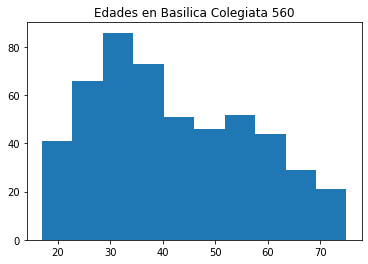

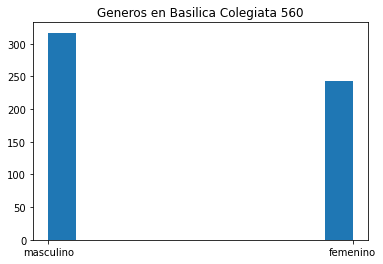

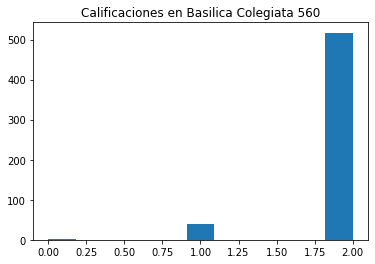

------------------------------
PUNTO 2
------------------------------
---------------Word Cloud---------------


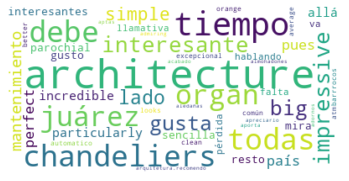

------------------------------
PUNTO 3
------------------------------
---------------Analisis LSA---------------
------------OPINIONES HOMBRES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
guanajuato  0.296166  0.114835 -0.243422     0.296166
ciudad      0.272456 -0.107929 -0.093400     0.272456
iglesia     0.215033 -0.084848  0.084969     0.215033
centro      0.205104 -0.064778 -0.142372     0.205104
noche       0.199425 -0.091268  0.303358     0.199425
lugar       0.189973 -0.070905 -0.199111     0.189973
basílica    0.181984 -0.060851  0.063090     0.181984
hermosa     0.178790 -0.078244  0.168150     0.178790
bonita      0.151936 -0.062637  0.310237     0.151936
visitar     0.147392 -0.050031 -0.004936     0.147392

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
beautiful  0.081348  0.308212  0.060417     0.081348     0.308212
church     0.068132  0.254666  0.035356     0.068132     0.254666
inside     0.052072  0.218331  0.066764     0.052072     0.218331
one        0.065168  0.216136 -0.022624     0.065168     0.216136
city       0.059170  0.211384  0.016998     0.059170     0.211384
basilica   0.086180  0.206852 -0.084594     0.086180     0.206852
see        0.052869  0.159604 -0.033454     0.052869     0.159604
great      0.039564  0.143895  0.056120     0.039564     0.143895
town       0.034206  0.142799  0.039615     0.034206     0.142799
visit      0.038405  0.137105  0.034408     0.038405     0.137105

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
bonita      0.151936 -0.062637  0.310237     0.151936     0.062637   
noche       0.199425 -0.091268  0.303358     0.199425     0.091268   
guanajuato  0.296166  0.114835 -0.243422     0.296166     0.114835   
dentro      0.140154 -0.058637  0.219561     0.140154     0.058637   
lugar       0.189973 -0.070905 -0.199111     0.189973     0.070905   
hermosa     0.178790 -0.078244  0.168150     0.178790     0.078244   
plaza       0.133347  0.007672  0.166255     0.133347     0.007672   
iluminada   0.060659 -0.028725  0.158803     0.060659     0.028725   
centro      0.205104 -0.064778 -0.142372     0.205104     0.064778   
visita      0.103978 -0.035845 -0.142284     0.103978     0.035845   

            abs_topic_3  
bonita         0.310237  
noche          0.303358  
guanajuato     0.243422  
dentro         0.219561  
lugar          0.199111  
hermosa        0.168150  
plaza          0.166255  
iluminada      0.158803  
centro         0.142372  
visita         0.142284

------------OPINIONES MUJERES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
ciudad        0.270127 -0.073931  0.160219     0.270127
guanajuato    0.256819  0.168817 -0.095920     0.256819
hermosa       0.240952 -0.068746  0.008400     0.240952
iglesia       0.228754 -0.052125 -0.008072     0.228754
basílica      0.198552 -0.062860  0.118196     0.198552
centro        0.187111 -0.044110  0.091166     0.187111
dentro        0.172694 -0.060644  0.278592     0.172694
noche         0.170303 -0.040260 -0.132036     0.170303
bonita        0.169603 -0.061218  0.278882     0.169603
arquitectura  0.168856 -0.035839  0.026232     0.168856

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
beautiful   0.065011  0.391472  0.035162     0.065011     0.391472
inside      0.048413  0.273386  0.023595     0.048413     0.273386
see         0.040860  0.243114  0.019839     0.040860     0.243114
church      0.034008  0.219302  0.028792     0.034008     0.219302
basilica    0.074731  0.214440 -0.006156     0.074731     0.214440
guanajuato  0.256819  0.168817 -0.095920     0.256819     0.168817
city        0.030064  0.160163 -0.003772     0.030064     0.160163
must        0.026266  0.151459  0.015774     0.026266     0.151459
visit       0.026584  0.147642  0.012526     0.026584     0.147642
amazing     0.022228  0.140504  0.014142     0.022228     0.140504

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
lugar       0.166124 -0.042867 -0.471164     0.166124     0.042867   
bonita      0.169603 -0.061218  0.278882     0.169603     0.061218   
dentro      0.172694 -0.060644  0.278592     0.172694     0.060644   
hermoso     0.099757 -0.004271 -0.215866     0.099757     0.004271   
bien        0.125604 -0.043882  0.187363     0.125604     0.043882   
conservada  0.082938 -0.033127  0.167360     0.082938     0.033127   
historia    0.098798 -0.028535 -0.162024     0.098798     0.028535   
ciudad      0.270127 -0.073931  0.160219     0.270127     0.073931   
noche       0.170303 -0.040260 -0.132036     0.170303     0.040260   
basílica    0.198552 -0.062860  0.118196     0.198552     0.062860   

            abs_topic_3  
lugar          0.471164  
bonita         0.278882  
dentro         0.278592  
hermoso        0.215866  
bien           0.187363  
conservada     0.167360  
historia       0.162024  
ciudad         0.160219  
noche          0.132036  
basílica       0.118196

------------OPINIONES NACIONALES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
guanajuato    0.291583 -0.271619  0.194984     0.291583
ciudad        0.259179 -0.018954 -0.278012     0.259179
hermosa       0.220035  0.116609 -0.327562     0.220035
lugar         0.211086 -0.383935  0.165120     0.211086
centro        0.199226 -0.000864 -0.249101     0.199226
bonita        0.195625  0.384197  0.214636     0.195625
basílica      0.195265  0.092660  0.015266     0.195265
iglesia       0.187824  0.027384 -0.032274     0.187824
arquitectura  0.180592 -0.119726 -0.078735     0.180592
noche         0.172482  0.125559 -0.183121     0.172482

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
bonita        0.195625  0.384197  0.214636     0.195625     0.384197
lugar         0.211086 -0.383935  0.165120     0.211086     0.383935
guanajuato    0.291583 -0.271619  0.194984     0.291583     0.271619
hermoso       0.098504 -0.250649  0.119622     0.098504     0.250649
dentro        0.158278  0.241694  0.128686     0.158278     0.241694
vale          0.108693  0.168981  0.163058     0.108693     0.168981
pena          0.108968  0.165099  0.180091     0.108968     0.165099
noche         0.172482  0.125559 -0.183121     0.172482     0.125559
arquitectura  0.180592 -0.119726 -0.078735     0.180592     0.119726
conocer       0.052243 -0.117034  0.033905     0.052243     0.117034

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
hermosa     0.220035  0.116609 -0.327562     0.220035     0.116609   
ciudad      0.259179 -0.018954 -0.278012     0.259179     0.018954   
centro      0.199226 -0.000864 -0.249101     0.199226     0.000864   
bonita      0.195625  0.384197  0.214636     0.195625     0.384197   
guanajuato  0.291583 -0.271619  0.194984     0.291583     0.271619   
noche       0.172482  0.125559 -0.183121     0.172482     0.125559   
pena        0.108968  0.165099  0.180091     0.108968     0.165099   
si          0.163339  0.003967  0.166298     0.163339     0.003967   
lugar       0.211086 -0.383935  0.165120     0.211086     0.383935   
vale        0.108693  0.168981  0.163058     0.108693     0.168981   

            abs_topic_3  
hermosa        0.327562  
ciudad         0.278012  
centro         0.249101  
bonita         0.214636  
guanajuato     0.194984  
noche          0.183121  
pena           0.180091  
si             0.166298  
lugar          0.165120  
vale           0.163058

------------OPINIONES INTERNACIONALES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
beautiful   0.318100 -0.101510 -0.018306     0.318100
inside      0.248412 -0.086929 -0.192207     0.248412
guanajuato  0.246695  0.123392  0.180063     0.246695
basilica    0.241643 -0.052134  0.258282     0.241643
church      0.225017 -0.072685 -0.242999     0.225017
city        0.191719 -0.056909  0.064424     0.191719
see         0.189392 -0.056308  0.093725     0.189392
one         0.187316 -0.054312  0.309091     0.187316
must        0.128416 -0.039712  0.035158     0.128416
visit       0.126893 -0.038840 -0.063413     0.126893

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
ciudad    0.071426  0.310251  0.068967     0.071426     0.310251
iglesia   0.067786  0.304606 -0.045309     0.067786     0.304606
noche     0.044682  0.209241 -0.193014     0.044682     0.209241
centro    0.057706  0.200611  0.006610     0.057706     0.200611
hermosa   0.039616  0.193046 -0.077243     0.039616     0.193046
basílica  0.041036  0.174331  0.050721     0.041036     0.174331
amarillo  0.035292  0.137099  0.066170     0.035292     0.137099
dentro    0.025664  0.136708 -0.061692     0.025664     0.136708
día       0.029722  0.135878 -0.137747     0.029722     0.135878
plaza     0.086092  0.132959 -0.059230     0.086092     0.132959

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
one          0.187316 -0.054312  0.309091     0.187316     0.054312   
basilica     0.241643 -0.052134  0.258282     0.241643     0.052134   
church       0.225017 -0.072685 -0.242999     0.225017     0.072685   
noche        0.044682  0.209241 -0.193014     0.044682     0.209241   
inside       0.248412 -0.086929 -0.192207     0.248412     0.086929   
guanajuato   0.246695  0.123392  0.180063     0.246695     0.123392   
día          0.029722  0.135878 -0.137747     0.029722     0.135878   
pena         0.022057  0.091518  0.124889     0.022057     0.091518   
vale         0.022057  0.091518  0.124889     0.022057     0.091518   
iluminación  0.013601  0.075178 -0.121013     0.013601     0.075178   

             abs_topic_3  
one             0.309091  
basilica        0.258282  
church          0.242999  
noche           0.193014  
inside          0.192207  
guanajuato      0.180063  
día             0.137747  
pena            0.124889  
vale            0.124889  
iluminación     0.121013

------------OPINIONES JOVENES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
guanajuato  0.281724  0.147785 -0.229722     0.281724
ciudad      0.258587 -0.068086 -0.153209     0.258587
basílica    0.236708 -0.049109  0.100710     0.236708
noche       0.212986 -0.057553  0.237650     0.212986
iglesia     0.210025 -0.044560 -0.064452     0.210025
centro      0.200101 -0.044197 -0.190373     0.200101
dentro      0.184220 -0.048111  0.164228     0.184220
hermosa     0.165369 -0.033292  0.127229     0.165369
lugar       0.164783 -0.010453 -0.323995     0.164783
bonita      0.149217 -0.053006  0.255012     0.149217

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
beautiful  0.033715  0.396910  0.049813     0.033715     0.396910
church     0.021031  0.242596  0.017822     0.021031     0.242596
basilica   0.074670  0.208482  0.045317     0.074670     0.208482
inside     0.015763  0.207163  0.037570     0.015763     0.207163
one        0.018293  0.170100  0.014981     0.018293     0.170100
around     0.012891  0.163498  0.024794     0.012891     0.163498
city       0.017351  0.162338  0.006458     0.017351     0.162338
center     0.012449  0.156642  0.030773     0.012449     0.156642
great      0.013093  0.154796  0.009369     0.013093     0.154796
visit      0.013967  0.148205 -0.012840     0.013967     0.148205

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
lugar       0.164783 -0.010453 -0.323995     0.164783     0.010453   
bonita      0.149217 -0.053006  0.255012     0.149217     0.053006   
noche       0.212986 -0.057553  0.237650     0.212986     0.057553   
guanajuato  0.281724  0.147785 -0.229722     0.281724     0.147785   
centro      0.200101 -0.044197 -0.190373     0.200101     0.044197   
pena        0.114844 -0.029550  0.187453     0.114844     0.029550   
vale        0.115405 -0.029310  0.184216     0.115405     0.029310   
dentro      0.184220 -0.048111  0.164228     0.184220     0.048111   
ciudad      0.258587 -0.068086 -0.153209     0.258587     0.068086   
conservada  0.073732 -0.020076  0.139517     0.073732     0.020076   

            abs_topic_3  
lugar          0.323995  
bonita         0.255012  
noche          0.237650  
guanajuato     0.229722  
centro         0.190373  
pena           0.187453  
vale           0.184216  
dentro         0.164228  
ciudad         0.153209  
conservada     0.139517

------------OPINIONES MAYORES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
guanajuato  0.279146  0.077165 -0.004480     0.279146
beautiful   0.254872 -0.193370  0.029573     0.254872
basilica    0.207911 -0.115201 -0.026382     0.207911
ciudad      0.192556  0.321305 -0.153212     0.192556
inside      0.181574 -0.147619  0.024812     0.181574
church      0.179703 -0.143580  0.042919     0.179703
see         0.174368 -0.128644  0.008228     0.174368
one         0.168242 -0.114995 -0.010114     0.168242
centro      0.150221  0.183296 -0.197725     0.150221
interior    0.137837  0.121565 -0.088690     0.137837

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
ciudad     0.192556  0.321305 -0.153212     0.192556     0.321305
beautiful  0.254872 -0.193370  0.029573     0.254872     0.193370
iglesia    0.112725  0.191709 -0.021512     0.112725     0.191709
hermosa    0.108764  0.185040  0.050649     0.108764     0.185040
centro     0.150221  0.183296 -0.197725     0.150221     0.183296
inside     0.181574 -0.147619  0.024812     0.181574     0.147619
church     0.179703 -0.143580  0.042919     0.179703     0.143580
noche      0.089506  0.143575 -0.058566     0.089506     0.143575
see        0.174368 -0.128644  0.008228     0.174368     0.128644
interior   0.137837  0.121565 -0.088690     0.137837     0.121565

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
pena        0.044147  0.079462  0.335861     0.044147     0.079462   
vale        0.038813  0.073624  0.321102     0.038813     0.073624   
iglesias    0.056638  0.092751  0.211840     0.056638     0.092751   
centro      0.150221  0.183296 -0.197725     0.150221     0.183296   
bien        0.047403  0.083970  0.179949     0.047403     0.083970   
basílica    0.066547  0.105788  0.172983     0.066547     0.105788   
dentro      0.035137  0.073465  0.167327     0.035137     0.073465   
conservada  0.017593  0.030844  0.159297     0.017593     0.030844   
ciudad      0.192556  0.321305 -0.153212     0.192556     0.321305   
religioso   0.033756  0.044145  0.140771     0.033756     0.044145   

            abs_topic_3  
pena           0.335861  
vale           0.321102  
iglesias       0.211840  
centro         0.197725  
bien           0.179949  
basílica       0.172983  
dentro         0.167327  
conservada     0.159297  
ciudad         0.153212  
religioso      0.140771

------------------------------
PUNTO 4
------------------------------
---------------Word Cloud Uni, Bi, Tri---------------


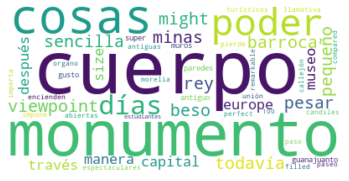

------------------------------
PUNTO 5
------------------------------
---------------Dispersion Plot---------------


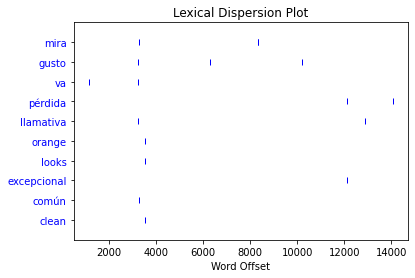

------------------------------
PUNTO 6
------------------------------
---------------Graficación libre---------------


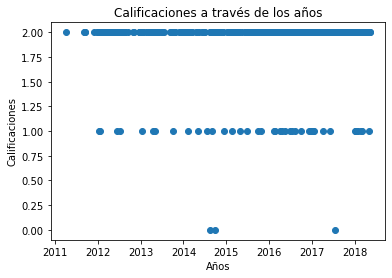

--------------------------------------------------------------------------------
MERCADO HIDALGO 600
--------------------------------------------------------------------------------
------------------------------
PUNTO 1
------------------------------
---------------Estadísticas---------------
PROMEDIO y DESVIACIÓN ESTÁNDAR DE CALIFICACIÓN POR LUGAR
promedio:  1.645
desviación estandar:  0.5879129754195485
LONGITUD PROMEDIO y DESVIACIÓN ESTÁNDAR DE OPINIONES POR LUGAR
promedio:  263.935
desviación estandar:  187.98388434916436


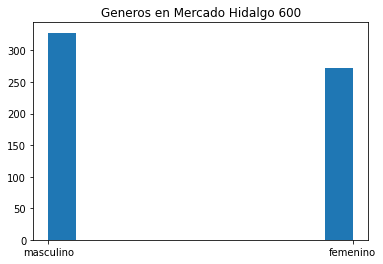

------------------------------
PUNTO 2
------------------------------
---------------Word Cloud---------------


------------------------------
PUNTO 3
------------------------------
---------------Analisis LSA---------------
------------OPINIONES HOMBRES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
mercado     0.337195 -0.061638  0.267630     0.337195
comida      0.262624 -0.116292  0.075050     0.262624
lugar       0.217851 -0.096533 -0.166860     0.217851
artesanías  0.165592 -0.077312  0.121915     0.165592
comprar     0.155856 -0.066687 -0.207163     0.155856
guanajuato  0.143566  0.029766 -0.077744     0.143566
comer       0.140544 -0.063663 -0.281544     0.140544
si          0.139527 -0.060384 -0.203972     0.139527
recuerdos   0.126693 -0.052123 -0.026627     0.126693
precios     0.124824 -0.050818 -0.119756     0.124824

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
market     0.115987  0.332512  0.004793     0.115987     0.332512
food       0.085126  0.251604 -0.024447     0.085126     0.251604
place      0.066569  0.199771  0.012111     0.066569     0.199771
stalls     0.042646  0.141839 -0.028980     0.042646     0.141839
mexican    0.042222  0.121778 -0.014025     0.042222     0.121778
buy        0.044354  0.117688 -0.019467     0.044354     0.117688
comida     0.262624 -0.116292  0.075050     0.262624     0.116292
building   0.036354  0.114825 -0.008232     0.036354     0.114825
great      0.044995  0.113806  0.020659     0.044995     0.113806
souvenirs  0.097457  0.109722  0.034875     0.097457     0.109722

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  abs_topic_3
comer     0.140544 -0.063663 -0.281544     0.140544     0.063663     0.281544
interior  0.071266 -0.026385  0.277239     0.071266     0.026385     0.277239
mercado   0.337195 -0.061638  0.267630     0.337195     0.061638     0.267630
comprar   0.155856 -0.066687 -0.207163     0.155856     0.066687     0.207163
si        0.139527 -0.060384 -0.203972     0.139527     0.060384     0.203972
lugar     0.217851 -0.096533 -0.166860     0.217851     0.096533     0.166860
típico    0.087845 -0.030504  0.147239     0.087845     0.030504     0.147239
dulces    0.105067 -0.045048  0.134095     0.105067     0.045048     0.134095
bonito    0.057288 -0.025196  0.131935     0.057288     0.025196     0.131935
bonita    0.037045 -0.014386  0.129739     0.037045     0.014386     0.129739

------------OPINIONES MUJERES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
mercado     0.341833 -0.034271  0.192178     0.341833
lugar       0.256414 -0.048001 -0.152109     0.256414
comida      0.236738 -0.042848 -0.016133     0.236738
si          0.202088 -0.027996 -0.247344     0.202088
comprar     0.174447 -0.031162 -0.067117     0.174447
dulces      0.167467 -0.029821  0.055239     0.167467
artesanías  0.166491 -0.032824  0.151735     0.166491
comer       0.161144 -0.027218 -0.275049     0.161144
buen        0.142116 -0.028296 -0.282835     0.142116
precios     0.131934 -0.023649  0.052727     0.131934

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
market     0.047620  0.382516  0.025727     0.047620     0.382516
food       0.043361  0.339381 -0.006450     0.043361     0.339381
great      0.024637  0.182746 -0.031593     0.024637     0.182746
buy        0.020705  0.158337  0.003680     0.020705     0.158337
souvenirs  0.057608  0.147590 -0.013278     0.057608     0.147590
local      0.043208  0.136773 -0.028635     0.043208     0.136773
stalls     0.017481  0.133467 -0.015832     0.017481     0.133467
visit      0.015264  0.129704  0.006385     0.015264     0.129704
lots       0.019789  0.127686 -0.024008     0.019789     0.127686
place      0.016553  0.122764 -0.004363     0.016553     0.122764

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
buen          0.142116 -0.028296 -0.282835     0.142116     0.028296   
comer         0.161144 -0.027218 -0.275049     0.161144     0.027218   
planta        0.082516 -0.017421  0.271859     0.082516     0.017421   
si            0.202088 -0.027996 -0.247344     0.202088     0.027996   
precio        0.112263 -0.022004 -0.197848     0.112263     0.022004   
edificio      0.078630 -0.015400  0.194036     0.078630     0.015400   
mercado       0.341833 -0.034271  0.192178     0.341833     0.034271   
lugar         0.256414 -0.048001 -0.152109     0.256414     0.048001   
artesanías    0.166491 -0.032824  0.151735     0.166491     0.032824   
arquitectura  0.093639 -0.015950  0.144675     0.093639     0.015950   

              abs_topic_3  
buen             0.282835  
comer            0.275049  
planta           0.271859  
si               0.247344  
precio           0.197848  
edificio         0.194036  
mercado          0.192178  
lugar            0.152109  
artesanías       0.151735  
arquitectura     0.144675

------------OPINIONES NACIONALES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
mercado     0.312562  0.122624  0.281314     0.312562
comida      0.266831  0.111374 -0.141307     0.266831
lugar       0.233622 -0.035030 -0.094007     0.233622
si          0.194299 -0.321495  0.053864     0.194299
artesanías  0.191479  0.249197 -0.163609     0.191479
comprar     0.170903 -0.101594 -0.121657     0.170903
dulces      0.165844  0.076291 -0.087099     0.165844
comer       0.152490 -0.303626 -0.094796     0.152490
precios     0.151394 -0.082520 -0.136150     0.151394
guanajuato  0.136689 -0.113162  0.110984     0.136689

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
si          0.194299 -0.321495  0.053864     0.194299     0.321495
comer       0.152490 -0.303626 -0.094796     0.152490     0.303626
planta      0.073231  0.260220 -0.112442     0.073231     0.260220
artesanías  0.191479  0.249197 -0.163609     0.191479     0.249197
alta        0.037832  0.149352 -0.065128     0.037832     0.149352
puede       0.072532  0.147818 -0.023807     0.072532     0.147818
baja        0.035589  0.142340 -0.050452     0.035589     0.142340
puestos     0.106126  0.139149 -0.040180     0.106126     0.139149
frutas      0.062846  0.132195 -0.064780     0.062846     0.132195
buen        0.125676 -0.128266 -0.112826     0.125676     0.128266

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
mercado     0.312562  0.122624  0.281314     0.312562     0.122624   
souvenirs   0.070783 -0.042680  0.205940     0.070783     0.042680   
market      0.010489 -0.015485  0.171087     0.010489     0.015485   
artesanías  0.191479  0.249197 -0.163609     0.191479     0.249197   
food        0.006928 -0.011778  0.156446     0.006928     0.011778   
place       0.004598  0.002378  0.152649     0.004598     0.002378   
interior    0.062508  0.118434  0.150898     0.062508     0.118434   
local       0.034855 -0.038650  0.143126     0.034855     0.038650   
comida      0.266831  0.111374 -0.141307     0.266831     0.111374   
precios     0.151394 -0.082520 -0.136150     0.151394     0.082520   

            abs_topic_3  
mercado        0.281314  
souvenirs      0.205940  
market         0.171087  
artesanías     0.163609  
food           0.156446  
place          0.152649  
interior       0.150898  
local          0.143126  
comida         0.141307  
precios        0.136150

------------OPINIONES INTERNACIONALES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
market     0.346434 -0.042417  0.284775     0.346434
food       0.287647 -0.038426  0.024580     0.287647
stalls     0.157582 -0.026878 -0.084895     0.157582
place      0.156232 -0.016860 -0.273953     0.156232
souvenirs  0.147841 -0.001626  0.006264     0.147841
buy        0.138460 -0.014594 -0.018222     0.138460
great      0.136281 -0.015359 -0.126428     0.136281
visit      0.128323 -0.014633  0.041507     0.128323
building   0.125131 -0.017009  0.083481     0.125131
like       0.122026 -0.010486 -0.025106     0.122026

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
mercado    0.075268  0.384123 -0.054293     0.075268     0.384123
lugar      0.016357  0.257217  0.094221     0.016357     0.257217
comida     0.012573  0.205469  0.006508     0.012573     0.205469
comprar    0.011983  0.186859  0.019915     0.011983     0.186859
recuerdos  0.009924  0.172701 -0.015047     0.009924     0.172701
comer      0.010041  0.162075  0.028920     0.010041     0.162075
puede      0.009749  0.137179  0.024943     0.009749     0.137179
buen       0.009396  0.131986  0.032520     0.009396     0.131986
gran       0.007453  0.122590  0.001619     0.007453     0.122590
aquí       0.007412  0.118564 -0.028421     0.007412     0.118564

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  abs_topic_3
market  0.346434 -0.042417  0.284775     0.346434     0.042417     0.284775
lots    0.120033 -0.019605 -0.275611     0.120033     0.019605     0.275611
place   0.156232 -0.016860 -0.273953     0.156232     0.016860     0.273953
floor   0.112137 -0.014211  0.250518     0.112137     0.014211     0.250518
local   0.117483  0.047198  0.194481     0.117483     0.047198     0.194481
get     0.078078 -0.014528 -0.177473     0.078078     0.014528     0.177473
large   0.056436 -0.006750  0.167775     0.056436     0.006750     0.167775
great   0.136281 -0.015359 -0.126428     0.136281     0.015359     0.126428
worth   0.106138 -0.016484  0.126244     0.106138     0.016484     0.126244
fresh   0.097794 -0.006670 -0.119987     0.097794     0.006670     0.119987

------------OPINIONES JOVENES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
mercado     0.338611 -0.008781 -0.288796     0.338611
comida      0.259384 -0.043753 -0.072688     0.259384
lugar       0.248755 -0.046332  0.067587     0.248755
si          0.197845 -0.030685  0.419979     0.197845
comprar     0.186568 -0.034903  0.162577     0.186568
artesanías  0.163552 -0.030525 -0.059060     0.163552
dulces      0.151356 -0.023073 -0.115723     0.151356
comer       0.149603 -0.027700  0.253203     0.149603
encontrar   0.128988 -0.017502 -0.030642     0.128988
guanajuato  0.125112  0.029691  0.067145     0.125112

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
market     0.038089  0.330063  0.016203     0.038089     0.330063
food       0.033258  0.308254  0.005371     0.033258     0.308254
place      0.021790  0.183925 -0.000176     0.021790     0.183925
stalls     0.016038  0.166054 -0.001579     0.016038     0.166054
buy        0.016432  0.150536  0.004542     0.016432     0.150536
great      0.018196  0.149429  0.005930     0.018196     0.149429
lots       0.015681  0.147494 -0.006656     0.015681     0.147494
souvenirs  0.058454  0.145391 -0.001246     0.058454     0.145391
like       0.017492  0.137294 -0.012370     0.017492     0.137294
items      0.014277  0.131076  0.006526     0.014277     0.131076

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
si            0.197845 -0.030685  0.419979     0.197845     0.030685   
mercado       0.338611 -0.008781 -0.288796     0.338611     0.008781   
arquitectura  0.117139 -0.018715 -0.254338     0.117139     0.018715   
comer         0.149603 -0.027700  0.253203     0.149603     0.027700   
comprar       0.186568 -0.034903  0.162577     0.186568     0.034903   
mexicano      0.054881 -0.008213 -0.152752     0.054881     0.008213   
dentro        0.099479 -0.019442 -0.134447     0.099479     0.019442   
encuentra     0.065515 -0.013759 -0.133965     0.065515     0.013759   
interior      0.058208 -0.009461 -0.133910     0.058208     0.009461   
mejor         0.098097 -0.018776  0.133513     0.098097     0.018776   

              abs_topic_3  
si               0.419979  
mercado          0.288796  
arquitectura     0.254338  
comer            0.253203  
comprar          0.162577  
mexicano         0.152752  
dentro           0.134447  
encuentra        0.133965  
interior         0.133910  
mejor            0.133513

------------OPINIONES MAYORES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
market     0.312628 -0.127204 -0.181396     0.312628
food       0.232556 -0.090725 -0.030444     0.232556
mercado    0.188274  0.381068  0.259191     0.188274
souvenirs  0.161852 -0.012504 -0.040495     0.161852
great      0.148066 -0.042208  0.079927     0.148066
find       0.147650 -0.042638 -0.049507     0.147650
buy        0.144837 -0.053754 -0.171834     0.144837
stalls     0.138789 -0.063942  0.112478     0.138789
local      0.129543 -0.009021  0.018272     0.129543
building   0.124225 -0.058481 -0.129454     0.124225

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
mercado     0.188274  0.381068  0.259191     0.188274     0.381068
comida      0.065805  0.232416 -0.122476     0.065805     0.232416
lugar       0.049165  0.160676 -0.012514     0.049165     0.160676
recuerdos   0.050866  0.155958 -0.154264     0.050866     0.155958
ciudad      0.040180  0.141715  0.021265     0.040180     0.141715
artesanías  0.033164  0.129209  0.015834     0.033164     0.129209
gran        0.033865  0.127919 -0.110651     0.033865     0.127919
market      0.312628 -0.127204 -0.181396     0.312628     0.127204
comer       0.035952  0.126131 -0.120356     0.035952     0.126131
aquí        0.035388  0.124015 -0.000328     0.035388     0.124015

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  abs_topic_3
mercado    0.188274  0.381068  0.259191     0.188274     0.381068     0.259191
market     0.312628 -0.127204 -0.181396     0.312628     0.127204     0.181396
vendors    0.121630 -0.034832  0.177801     0.121630     0.034832     0.177801
buy        0.144837 -0.053754 -0.171834     0.144837     0.053754     0.171834
fresh      0.106974 -0.025096  0.163608     0.106974     0.025096     0.163608
meat       0.097253 -0.032987  0.160023     0.097253     0.032987     0.160023
recuerdos  0.050866  0.155958 -0.154264     0.050866     0.155958     0.154264
lots       0.104849 -0.043126  0.133262     0.104849     0.043126     0.133262
fruit      0.067707 -0.023937  0.133163     0.067707     0.023937     0.133163
building   0.124225 -0.058481 -0.129454     0.124225     0.058481     0.129454

------------------------------
PUNTO 4
------------------------------
---------------Word Cloud Uni, Bi, Tri---------------


------------------------------
PUNTO 5
------------------------------
---------------Dispersion Plot---------------


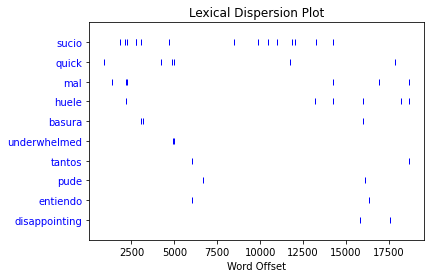

------------------------------
PUNTO 6
------------------------------
---------------Graficación libre---------------


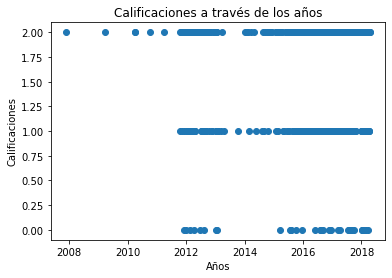

--------------------------------------------------------------------------------
CASA DE DIEGO RIVERA 698
--------------------------------------------------------------------------------
------------------------------
PUNTO 1
------------------------------
---------------Estadísticas---------------
PROMEDIO y DESVIACIÓN ESTÁNDAR DE CALIFICACIÓN POR LUGAR
promedio:  1.8094555873925502
desviación estandar:  0.44730583680278024
LONGITUD PROMEDIO y DESVIACIÓN ESTÁNDAR DE OPINIONES POR LUGAR
promedio:  277.1618911174785
desviación estandar:  166.72668086477037


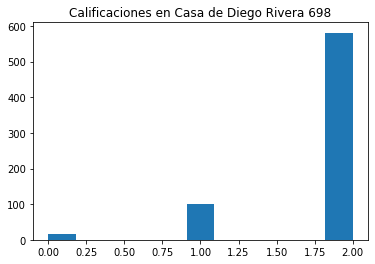

------------------------------
PUNTO 2
------------------------------
---------------Word Cloud---------------


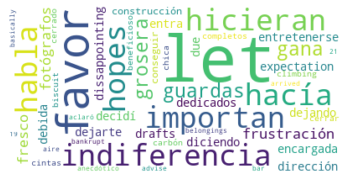

------------------------------
PUNTO 3
------------------------------
---------------Analisis LSA---------------
------------OPINIONES HOMBRES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
rivera       0.292152  0.098756 -0.083896     0.292152
diego        0.281274  0.142109 -0.026119     0.281274
museum       0.237142 -0.149365  0.265120     0.237142
art          0.214730 -0.133263 -0.095608     0.214730
work         0.203965 -0.127317 -0.086512     0.203965
home         0.174544 -0.110043  0.320933     0.174544
casa         0.145289  0.301079  0.007068     0.145289
house        0.134979 -0.080389 -0.233016     0.134979
interesting  0.128598 -0.077739 -0.073132     0.128598
artists      0.118271 -0.073518  0.188691     0.118271

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
casa    0.145289  0.301079  0.007068     0.145289     0.301079
obras   0.110333  0.252649 -0.011979     0.110333     0.252649
museo   0.106062  0.233053  0.049987     0.106062     0.233053
lugar   0.069776  0.156640 -0.004456     0.069776     0.156640
museum  0.237142 -0.149365  0.265120     0.237142     0.149365
diego   0.281274  0.142109 -0.026119     0.281274     0.142109
arte    0.062108  0.141296 -0.003248     0.062108     0.141296
si      0.062342  0.140576  0.026467     0.062342     0.140576
art     0.214730 -0.133263 -0.095608     0.214730     0.133263
bien    0.055700  0.128574 -0.038836     0.055700     0.128574

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  abs_topic_3
home       0.174544 -0.110043  0.320933     0.174544     0.110043     0.320933
works      0.117103 -0.074697  0.285525     0.117103     0.074697     0.285525
museum     0.237142 -0.149365  0.265120     0.237142     0.149365     0.265120
house      0.134979 -0.080389 -0.233016     0.134979     0.080389     0.233016
well       0.114356 -0.074591  0.218524     0.114356     0.074591     0.218524
years      0.084687 -0.054940 -0.201285     0.084687     0.054940     0.201285
artists    0.118271 -0.073518  0.188691     0.118271     0.073518     0.188691
see        0.115248 -0.073742 -0.159344     0.115248     0.073742     0.159344
displayed  0.044165 -0.030852  0.128715     0.044165     0.030852     0.128715
lovely     0.021331 -0.014008  0.121781     0.021331     0.014008     0.121781

------------OPINIONES MUJERES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
rivera       0.304308  0.095073  0.036849     0.304308
diego        0.296489  0.155619 -0.027921     0.296489
museum       0.245309 -0.129155  0.050493     0.245309
see          0.203544 -0.114580 -0.087522     0.203544
art          0.200401 -0.113287  0.034262     0.200401
house        0.184153 -0.094183 -0.401084     0.184153
work         0.183008 -0.103086  0.348464     0.183008
interesting  0.175342 -0.094712 -0.058952     0.175342
home         0.161835 -0.087538  0.305256     0.161835
well         0.146251 -0.077562 -0.040705     0.146251

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
casa      0.119943  0.309415  0.048683     0.119943     0.309415
obras     0.096104  0.251329 -0.009592     0.096104     0.251329
museo     0.093409  0.238958 -0.107727     0.093409     0.238958
lugar     0.060219  0.163204 -0.077808     0.060219     0.163204
diego     0.296489  0.155619 -0.027921     0.296489     0.155619
pinturas  0.053757  0.142469  0.042548     0.053757     0.142469
museum    0.245309 -0.129155  0.050493     0.245309     0.129155
artistas  0.050150  0.126867  0.036459     0.050150     0.126867
obra      0.044957  0.118394  0.046244     0.044957     0.118394
vivió     0.042788  0.115516  0.003903     0.042788     0.115516

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  abs_topic_3
house      0.184153 -0.094183 -0.401084     0.184153     0.094183     0.401084
work       0.183008 -0.103086  0.348464     0.183008     0.103086     0.348464
home       0.161835 -0.087538  0.305256     0.161835     0.087538     0.305256
works      0.127966 -0.068128  0.176786     0.127966     0.068128     0.176786
paintings  0.082106 -0.041480 -0.136107     0.082106     0.041480     0.136107
seeing     0.075980 -0.036711  0.133246     0.075980     0.036711     0.133246
also       0.099747 -0.055449  0.124652     0.099747     0.055449     0.124652
rooms      0.067238 -0.039159 -0.123581     0.067238     0.039159     0.123581
childhood  0.059554 -0.034689  0.122067     0.059554     0.034689     0.122067
one        0.062857 -0.038121 -0.115874     0.062857     0.038121     0.115874

------------OPINIONES NACIONALES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
diego         0.312145  0.173986 -0.030633     0.312145
casa          0.276910 -0.036115 -0.015103     0.276910
rivera        0.271169  0.214273 -0.010265     0.271169
obras         0.250145 -0.053758 -0.024764     0.250145
museo         0.235353 -0.038204 -0.051941     0.235353
lugar         0.157186 -0.064312  0.035450     0.157186
arte          0.152881 -0.049015 -0.156031     0.152881
exposiciones  0.141922 -0.016424 -0.235952     0.141922
si            0.137229 -0.043967 -0.180042     0.137229
artistas      0.127451 -0.002761 -0.160156     0.127451

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
house        0.019543  0.274571  0.015203     0.019543     0.274571
art          0.011402  0.234339  0.006630     0.011402     0.234339
work         0.011501  0.229732  0.008104     0.011501     0.229732
rivera       0.271169  0.214273 -0.010265     0.271169     0.214273
see          0.009429  0.205426  0.006230     0.009429     0.205426
interesting  0.010665  0.185641  0.013150     0.010665     0.185641
museum       0.009076  0.177891  0.003578     0.009076     0.177891
diego        0.312145  0.173986 -0.030633     0.312145     0.173986
works        0.008037  0.160124  0.013329     0.008037     0.160124
home         0.005579  0.144284  0.004649     0.005579     0.144284

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
vale          0.099726 -0.016528  0.388914     0.099726     0.016528   
pena          0.102935 -0.013728  0.384648     0.102935     0.013728   
exposiciones  0.141922 -0.016424 -0.235952     0.141922     0.016424   
temporales    0.071956 -0.010691 -0.180386     0.071956     0.010691   
si            0.137229 -0.043967 -0.180042     0.137229     0.043967   
muchas        0.064122 -0.015478  0.160673     0.064122     0.015478   
artistas      0.127451 -0.002761 -0.160156     0.127451     0.002761   
exposición    0.079713 -0.004455 -0.158652     0.079713     0.004455   
arte          0.152881 -0.049015 -0.156031     0.152881     0.049015   
gran          0.092568 -0.031255  0.148865     0.092568     0.031255   

              abs_topic_3  
vale             0.388914  
pena             0.384648  
exposiciones     0.235952  
temporales       0.180386  
si               0.180042  
muchas           0.160673  
artistas         0.160156  
exposición       0.158652  
arte             0.156031  
gran             0.148865

------------OPINIONES INTERNACIONALES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
rivera       0.266019  0.168984 -0.013438     0.266019
museum       0.264559 -0.057383 -0.093633     0.264559
diego        0.247680  0.197033 -0.006816     0.247680
art          0.226475 -0.057594 -0.147871     0.226475
work         0.211437 -0.053182 -0.189991     0.211437
home         0.191694 -0.041816 -0.334703     0.191694
see          0.176732 -0.047855  0.251049     0.176732
interesting  0.168506 -0.037866  0.102854     0.168506
house        0.164482 -0.037319  0.388724     0.164482
well         0.145740 -0.032247 -0.029930     0.145740

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
casa         0.041042  0.373990  0.015882     0.041042     0.373990
museo        0.026510  0.268196  0.000957     0.026510     0.268196
obras        0.023065  0.260229  0.009424     0.023065     0.260229
diego        0.247680  0.197033 -0.006816     0.247680     0.197033
lugar        0.018015  0.183062 -0.027607     0.018015     0.183062
rivera       0.266019  0.168984 -0.013438     0.266019     0.168984
interesante  0.012949  0.150348  0.010408     0.012949     0.150348
nació        0.014774  0.148007  0.010618     0.014774     0.148007
artista      0.010135  0.145952 -0.004497     0.010135     0.145952
obra         0.013361  0.145769 -0.002234     0.013361     0.145769

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
house       0.164482 -0.037319  0.388724     0.164482     0.037319   
home        0.191694 -0.041816 -0.334703     0.191694     0.041816   
see         0.176732 -0.047855  0.251049     0.176732     0.047855   
work        0.211437 -0.053182 -0.189991     0.211437     0.053182   
paintings   0.083878 -0.012577  0.188143     0.083878     0.012577   
years       0.088067 -0.033001  0.161296     0.088067     0.033001   
works       0.135483 -0.031912 -0.157930     0.135483     0.031912   
enjoyed     0.107732 -0.023260 -0.155839     0.107732     0.023260   
art         0.226475 -0.057594 -0.147871     0.226475     0.057594   
collection  0.100691 -0.020001 -0.142412     0.100691     0.020001   

            abs_topic_3  
house          0.388724  
home           0.334703  
see            0.251049  
work           0.189991  
paintings      0.188143  
years          0.161296  
works          0.157930  
enjoyed        0.155839  
art            0.147871  
collection     0.142412

------------OPINIONES JOVENES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2       topic_3  abs_topic_1
diego     0.316673 -0.003680 -2.873401e-02     0.316673
rivera    0.290229  0.031218  1.025924e-02     0.290229
casa      0.263691 -0.191962  5.237354e-03     0.263691
obras     0.200346 -0.150709 -1.775264e-01     0.200346
museo     0.162749 -0.113332 -1.317838e-01     0.162749
museum    0.141270  0.239795 -4.835689e-07     0.141270
art       0.132999  0.236708  1.165431e-02     0.132999
artistas  0.128291 -0.093573 -5.208542e-02     0.128291
work      0.122912  0.215350  1.447872e-02     0.122912
pinturas  0.122460 -0.091173  8.829569e-02     0.122460

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2       topic_3  abs_topic_1  abs_topic_2
museum  0.141270  0.239795 -4.835689e-07     0.141270     0.239795
art     0.132999  0.236708  1.165431e-02     0.132999     0.236708
work    0.122912  0.215350  1.447872e-02     0.122912     0.215350
casa    0.263691 -0.191962  5.237354e-03     0.263691     0.191962
home    0.102769  0.186037  2.123581e-02     0.102769     0.186037
see     0.092858  0.161178 -7.385348e-03     0.092858     0.161178
visit   0.086986  0.151538  1.570278e-02     0.086986     0.151538
obras   0.200346 -0.150709 -1.775264e-01     0.200346     0.150709
house   0.084071  0.145319 -2.187412e-02     0.084071     0.145319
well    0.080000  0.142640 -2.230302e-02     0.080000     0.142640

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
pena          0.101485 -0.076955  0.469024     0.101485     0.076955   
vale          0.099161 -0.075526  0.467571     0.099161     0.075526   
arte          0.115571 -0.087348 -0.210931     0.115571     0.087348   
obra          0.105443 -0.079480  0.197960     0.105443     0.079480   
si            0.092362 -0.071121 -0.179766     0.092362     0.071121   
obras         0.200346 -0.150709 -0.177526     0.200346     0.150709   
museo         0.162749 -0.113332 -0.131784     0.162749     0.113332   
época         0.079749 -0.062310  0.130671     0.079749     0.062310   
exposiciones  0.094262 -0.069402 -0.118834     0.094262     0.069402   
gran          0.067731 -0.050491  0.091394     0.067731     0.050491   

              abs_topic_3  
pena             0.469024  
vale             0.467571  
arte             0.210931  
obra             0.197960  
si               0.179766  
obras            0.177526  
museo            0.131784  
época            0.130671  
exposiciones     0.118834  
gran             0.091394

------------OPINIONES MAYORES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
rivera       0.289635  0.142164  0.043899     0.289635
diego        0.257046  0.180996 -0.031667     0.257046
museum       0.247040 -0.082171 -0.140286     0.247040
work         0.232251 -0.075111  0.071313     0.232251
art          0.201489 -0.064354  0.439166     0.201489
home         0.188274 -0.051594 -0.216054     0.188274
see          0.187012 -0.059879 -0.181045     0.187012
interesting  0.174183 -0.056555 -0.060993     0.174183
house        0.155538 -0.046426 -0.018701     0.155538
works        0.146232 -0.036692 -0.216697     0.146232

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
casa     0.054386  0.305632  0.009929     0.054386     0.305632
obras    0.045006  0.295183  0.003768     0.045006     0.295183
museo    0.046177  0.289329  0.014772     0.046177     0.289329
diego    0.257046  0.180996 -0.031667     0.257046     0.180996
bien     0.030453  0.179627  0.011933     0.030453     0.179627
ver      0.030899  0.158415 -0.001185     0.030899     0.158415
lugar    0.025498  0.155787 -0.018749     0.025498     0.155787
pintor   0.018454  0.144902  0.027608     0.018454     0.144902
rivera   0.289635  0.142164  0.043899     0.289635     0.142164
artista  0.014319  0.128844 -0.011643     0.014319     0.128844

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  abs_topic_3
art     0.201489 -0.064354  0.439166     0.201489     0.064354     0.439166
place   0.059245 -0.018052  0.294629     0.059245     0.018052     0.294629
works   0.146232 -0.036692 -0.216697     0.146232     0.036692     0.216697
home    0.188274 -0.051594 -0.216054     0.188274     0.051594     0.216054
visit   0.124513 -0.036458  0.213175     0.124513     0.036458     0.213175
see     0.187012 -0.059879 -0.181045     0.187012     0.059879     0.181045
nice    0.093930 -0.020200  0.175038     0.093930     0.020200     0.175038
like    0.056067 -0.013522  0.149999     0.056067     0.013522     0.149999
museum  0.247040 -0.082171 -0.140286     0.247040     0.082171     0.140286
take    0.036252 -0.007980  0.133213     0.036252     0.007980     0.133213

------------------------------
PUNTO 4
------------------------------
---------------Word Cloud Uni, Bi, Tri---------------


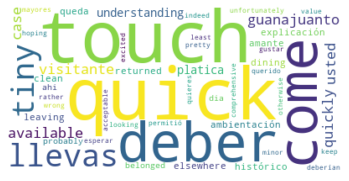

------------------------------
PUNTO 5
------------------------------
---------------Dispersion Plot---------------


------------------------------
PUNTO 6
------------------------------
---------------Graficación libre---------------


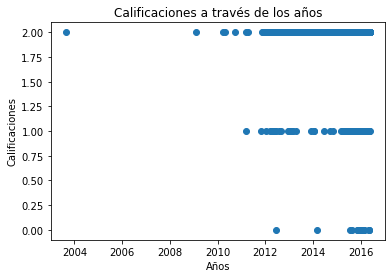

--------------------------------------------------------------------------------
UNIVERSIDAD DE GUANAJUATO 900
--------------------------------------------------------------------------------
------------------------------
PUNTO 1
------------------------------
---------------Estadísticas---------------
PROMEDIO y DESVIACIÓN ESTÁNDAR DE CALIFICACIÓN POR LUGAR
promedio:  1.94
desviación estandar:  0.255516905289824
LONGITUD PROMEDIO y DESVIACIÓN ESTÁNDAR DE OPINIONES POR LUGAR
promedio:  208.56666666666666
desviación estandar:  115.25372493377866


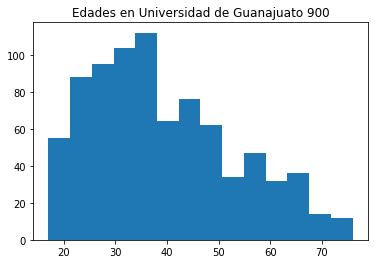

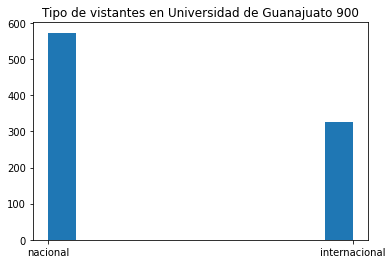

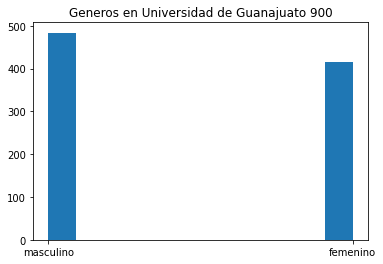

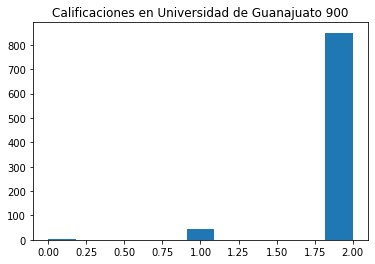

------------------------------
PUNTO 2
------------------------------
---------------Word Cloud---------------


------------------------------
PUNTO 3
------------------------------
---------------Analisis LSA---------------
------------OPINIONES HOMBRES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
guanajuato    0.303526  0.139395 -0.328152     0.303526
lugar         0.293794 -0.024930  0.082958     0.293794
ciudad        0.259019 -0.029030 -0.068327     0.259019
universidad   0.255525 -0.011331 -0.197259     0.255525
edificio      0.216920 -0.028313 -0.004922     0.216920
arquitectura  0.211711 -0.023998  0.012725     0.211711
si            0.168459 -0.003331 -0.124338     0.168459
visitar       0.167587 -0.001974 -0.157669     0.167587
vista         0.164159 -0.025817  0.047292     0.164159
subir         0.147740 -0.027391  0.152506     0.147740

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
building    0.015639  0.347888  0.035515     0.015639     0.347888
university  0.012989  0.293072  0.024728     0.012989     0.293072
city        0.012157  0.243516  0.019442     0.012157     0.243516
great       0.007535  0.206051  0.028757     0.007535     0.206051
beautiful   0.007060  0.199145  0.028186     0.007060     0.199145
stairs      0.007712  0.193792  0.025261     0.007712     0.193792
steps       0.008120  0.185657  0.015246     0.008120     0.185657
climb       0.003866  0.168969  0.033021     0.003866     0.168969
visit       0.010350  0.165735  0.014857     0.010350     0.165735
view        0.007049  0.157915  0.012877     0.007049     0.157915

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
pena         0.134960 -0.029843  0.406158     0.134960     0.029843   
vale         0.138586 -0.030204  0.403882     0.138586     0.030204   
guanajuato   0.303526  0.139395 -0.328152     0.303526     0.139395   
fotos        0.087005 -0.017829  0.207683     0.087005     0.017829   
universidad  0.255525 -0.011331 -0.197259     0.255525     0.011331   
visitar      0.167587 -0.001974 -0.157669     0.167587     0.001974   
subir        0.147740 -0.027391  0.152506     0.147740     0.027391   
tomarse      0.056279 -0.011137  0.140470     0.056279     0.011137   
tomar        0.046576 -0.010600  0.131516     0.046576     0.010600   
muchas       0.056842 -0.010765  0.129168     0.056842     0.010765   

             abs_topic_3  
pena            0.406158  
vale            0.403882  
guanajuato      0.328152  
fotos           0.207683  
universidad     0.197259  
visitar         0.157669  
subir           0.152506  
tomarse         0.140470  
tomar           0.131516  
muchas          0.129168

------------OPINIONES MUJERES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
universidad   0.292990 -0.013249  0.103673     0.292990
guanajuato    0.285506  0.121731 -0.079987     0.285506
edificio      0.245954 -0.021377 -0.047079     0.245954
ciudad        0.211511 -0.011236  0.093871     0.211511
arquitectura  0.197302  0.014601 -0.103844     0.197302
lugar         0.187120  0.007052 -0.463150     0.187120
vista         0.186348 -0.013361  0.151472     0.186348
escaleras     0.172044 -0.017841  0.072309     0.172044
hermosa       0.150630 -0.019741  0.073978     0.150630
subir         0.150498 -0.017161  0.108325     0.150498

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
building      0.008217  0.321893  0.016870     0.008217     0.321893
beautiful     0.006146  0.264774  0.017054     0.006146     0.264774
university    0.006377  0.248231  0.026987     0.006377     0.248231
stairs        0.006151  0.240895  0.000914     0.006151     0.240895
architecture  0.005637  0.235385  0.013237     0.005637     0.235385
great         0.008046  0.222496 -0.005534     0.008046     0.222496
view          0.007598  0.221011 -0.007747     0.007598     0.221011
top           0.008496  0.201887 -0.002773     0.008496     0.201887
worth         0.002103  0.186600  0.011014     0.002103     0.186600
steps         0.003558  0.162132  0.017343     0.003558     0.162132

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  abs_topic_3
lugar      0.187120  0.007052 -0.463150     0.187120     0.007052     0.463150
pena       0.128578 -0.027910  0.372971     0.128578     0.027910     0.372971
vale       0.126891 -0.027704  0.365263     0.126891     0.027704     0.365263
vista      0.186348 -0.013361  0.151472     0.186348     0.013361     0.151472
visitar    0.104095 -0.000320 -0.130573     0.104095     0.000320     0.130573
historia   0.126961 -0.000229 -0.123945     0.126961     0.000229     0.123945
si         0.147544 -0.023860 -0.113232     0.147544     0.023860     0.113232
subir      0.150498 -0.017161  0.108325     0.150498     0.017161     0.108325
bonita     0.075301 -0.023819  0.108163     0.075301     0.023819     0.108163
visitarla  0.049742 -0.015804  0.105551     0.049742     0.015804     0.105551

------------OPINIONES NACIONALES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
guanajuato    0.305008 -0.313396 -0.156438     0.305008
lugar         0.270705 -0.288632  0.572076     0.270705
universidad   0.237888 -0.037713 -0.251036     0.237888
ciudad        0.223422 -0.008062 -0.117784     0.223422
arquitectura  0.210772 -0.093301  0.012589     0.210772
edificio      0.210231  0.075429 -0.189384     0.210231
vista         0.172338  0.055986 -0.144305     0.172338
si            0.165326 -0.117638 -0.006199     0.165326
escaleras     0.159060  0.055635  0.010990     0.159060
visitar       0.155241 -0.165567  0.100460     0.155241

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
pena        0.133422  0.414570  0.086954     0.133422     0.414570
vale        0.136648  0.408330  0.094465     0.136648     0.408330
guanajuato  0.305008 -0.313396 -0.156438     0.305008     0.313396
lugar       0.270705 -0.288632  0.572076     0.270705     0.288632
subir       0.154209  0.186494  0.026986     0.154209     0.186494
visitar     0.155241 -0.165567  0.100460     0.155241     0.165567
fotos       0.094241  0.162229  0.190679     0.094241     0.162229
tomar       0.067917  0.128292  0.108321     0.067917     0.128292
entrar      0.056417  0.121548 -0.047131     0.056417     0.121548
escalones   0.104278  0.119287 -0.025335     0.104278     0.119287

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
lugar          0.270705 -0.288632  0.572076     0.270705     0.288632   
universidad    0.237888 -0.037713 -0.251036     0.237888     0.037713   
fotos          0.094241  0.162229  0.190679     0.094241     0.162229   
edificio       0.210231  0.075429 -0.189384     0.210231     0.075429   
foto           0.126492  0.012460  0.168391     0.126492     0.012460   
tomarse        0.051597  0.074390  0.156800     0.051597     0.074390   
guanajuato     0.305008 -0.313396 -0.156438     0.305008     0.313396   
vista          0.172338  0.055986 -0.144305     0.172338     0.055986   
bonito         0.099325  0.042645  0.136981     0.099325     0.042645   
impresionante  0.100059 -0.037033 -0.133143     0.100059     0.037033   

               abs_topic_3  
lugar             0.572076  
universidad       0.251036  
fotos             0.190679  
edificio          0.189384  
foto              0.168391  
tomarse           0.156800  
guanajuato        0.156438  
vista             0.144305  
bonito            0.136981  
impresionante     0.133143

------------OPINIONES INTERNACIONALES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
universidad  0.271089 -0.249865 -0.055007     0.271089
guanajuato   0.265371 -0.063966 -0.204989     0.265371
edificio     0.216169 -0.203660 -0.041218     0.216169
ciudad       0.205424 -0.192655  0.097930     0.205424
building     0.194877  0.230064  0.038897     0.194877
university   0.166811  0.187177 -0.198784     0.166811
stairs       0.155055  0.181714  0.285682     0.155055
beautiful    0.144540  0.167655  0.062628     0.144540
hermosa      0.142126 -0.136386  0.124625     0.142126
great        0.132430  0.153912  0.240367     0.132430

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
universidad  0.271089 -0.249865 -0.055007     0.271089     0.249865
building     0.194877  0.230064  0.038897     0.194877     0.230064
edificio     0.216169 -0.203660 -0.041218     0.216169     0.203660
ciudad       0.205424 -0.192655  0.097930     0.205424     0.192655
university   0.166811  0.187177 -0.198784     0.166811     0.187177
stairs       0.155055  0.181714  0.285682     0.155055     0.181714
beautiful    0.144540  0.167655  0.062628     0.144540     0.167655
great        0.132430  0.153912  0.240367     0.132430     0.153912
city         0.126285  0.149365 -0.065166     0.126285     0.149365
steps        0.123026  0.142230 -0.116492     0.123026     0.142230

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
stairs      0.155055  0.181714  0.285682     0.155055     0.181714   
top         0.098841  0.104694  0.258227     0.098841     0.104694   
great       0.132430  0.153912  0.240367     0.132430     0.153912   
guanajuato  0.265371 -0.063966 -0.204989     0.265371     0.063966   
university  0.166811  0.187177 -0.198784     0.166811     0.187177   
view        0.103657  0.120092  0.189484     0.103657     0.120092   
vale        0.084259 -0.082720  0.168323     0.084259     0.082720   
pena        0.088594 -0.086379  0.165586     0.088594     0.086379   
vista       0.124300 -0.117897  0.157660     0.124300     0.117897   
pipila      0.061742  0.032851  0.150708     0.061742     0.032851   

            abs_topic_3  
stairs         0.285682  
top            0.258227  
great          0.240367  
guanajuato     0.204989  
university     0.198784  
view           0.189484  
vale           0.168323  
pena           0.165586  
vista          0.157660  
pipila         0.150708

------------OPINIONES JOVENES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
guanajuato    0.288357  0.173799  0.013801     0.288357
lugar         0.280819  0.002462  0.547603     0.280819
universidad   0.259217  0.007084 -0.148318     0.259217
ciudad        0.237534 -0.032428 -0.240364     0.237534
arquitectura  0.211760 -0.015765  0.093281     0.211760
edificio      0.210878 -0.011461 -0.194576     0.210878
vista         0.173747 -0.040262 -0.161097     0.173747
si            0.170530 -0.002623  0.006247     0.170530
visitar       0.161371  0.027047  0.146804     0.161371
escaleras     0.157362 -0.030575  0.012512     0.157362

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
building    0.009929  0.328968 -0.007609     0.009929     0.328968
great       0.009840  0.285215 -0.005700     0.009840     0.285215
city        0.006870  0.244434 -0.009000     0.006870     0.244434
beautiful   0.005277  0.228289 -0.012322     0.005277     0.228289
university  0.005869  0.223129 -0.015781     0.005869     0.223129
stairs      0.004808  0.199212 -0.007641     0.004808     0.199212
view        0.008771  0.195975 -0.002729     0.008771     0.195975
guanajuato  0.288357  0.173799  0.013801     0.288357     0.173799
steps       0.003683  0.172897 -0.013024     0.003683     0.172897
go          0.005167  0.160383 -0.009437     0.005167     0.160383

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
lugar        0.280819  0.002462  0.547603     0.280819     0.002462   
ciudad       0.237534 -0.032428 -0.240364     0.237534     0.032428   
edificio     0.210878 -0.011461 -0.194576     0.210878     0.011461   
foto         0.114100 -0.020816  0.187341     0.114100     0.020816   
buen         0.059077 -0.008932  0.170108     0.059077     0.008932   
vista        0.173747 -0.040262 -0.161097     0.173747     0.040262   
universidad  0.259217  0.007084 -0.148318     0.259217     0.007084   
visitar      0.161371  0.027047  0.146804     0.161371     0.027047   
hermosa      0.136231 -0.031375 -0.142178     0.136231     0.031375   
vale         0.118050 -0.034242 -0.141042     0.118050     0.034242   

             abs_topic_3  
lugar           0.547603  
ciudad          0.240364  
edificio        0.194576  
foto            0.187341  
buen            0.170108  
vista           0.161097  
universidad     0.148318  
visitar         0.146804  
hermosa         0.142178  
vale            0.141042

------------OPINIONES MAYORES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
guanajuato   0.306783  0.124276 -0.026734     0.306783
universidad  0.293307 -0.036047 -0.295818     0.293307
edificio     0.284070 -0.062993  0.012278     0.284070
ciudad       0.231904 -0.026260 -0.253009     0.231904
si           0.156249 -0.033013  0.301256     0.156249
subir        0.152407 -0.026990  0.087636     0.152407
lugar        0.139233 -0.019238  0.220161     0.139233
escalinata   0.126162 -0.013959  0.063405     0.126162
escalera     0.122693 -0.022753 -0.074297     0.122693
escaleras    0.120319 -0.024815 -0.014174     0.120319

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
university  0.031034  0.327250  0.016651     0.031034     0.327250
building    0.027868  0.260176 -0.015431     0.027868     0.260176
place       0.016388  0.229366  0.007255     0.016388     0.229366
stairs      0.020176  0.213535  0.009792     0.020176     0.213535
town        0.016963  0.161673 -0.008350     0.016963     0.161673
steps       0.014158  0.161190 -0.003899     0.014158     0.161190
view        0.011971  0.158522  0.008051     0.011971     0.158522
around      0.013907  0.155196 -0.000178     0.013907     0.155196
worth       0.011046  0.154594  0.010823     0.011046     0.154594
see         0.010044  0.154412  0.015376     0.010044     0.154412

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
si           0.156249 -0.033013  0.301256     0.156249     0.033013   
universidad  0.293307 -0.036047 -0.295818     0.293307     0.036047   
fotos        0.094234 -0.018538  0.261388     0.094234     0.018538   
ciudad       0.231904 -0.026260 -0.253009     0.231904     0.026260   
lugar        0.139233 -0.019238  0.220161     0.139233     0.019238   
bonito       0.095747 -0.011475  0.156079     0.095747     0.011475   
visita       0.084966 -0.000846  0.130301     0.084966     0.000846   
verla        0.054944 -0.013096  0.115591     0.054944     0.013096   
conocerla    0.030723 -0.003024  0.107413     0.030723     0.003024   
tomarte      0.030723 -0.003024  0.107413     0.030723     0.003024   

             abs_topic_3  
si              0.301256  
universidad     0.295818  
fotos           0.261388  
ciudad          0.253009  
lugar           0.220161  
bonito          0.156079  
visita          0.130301  
verla           0.115591  
conocerla       0.107413  
tomarte         0.107413

------------------------------
PUNTO 4
------------------------------
---------------Word Cloud Uni, Bi, Tri---------------


------------------------------
PUNTO 5
------------------------------
---------------Dispersion Plot---------------


------------------------------
PUNTO 6
------------------------------
---------------Graficación libre---------------


--------------------------------------------------------------------------------
ALHÓNDIGA 930
--------------------------------------------------------------------------------
------------------------------
PUNTO 1
------------------------------
---------------Estadísticas---------------
PROMEDIO y DESVIACIÓN ESTÁNDAR DE CALIFICACIÓN POR LUGAR
promedio:  1.8849462365591398
desviación estandar:  0.37486807329820665
LONGITUD PROMEDIO y DESVIACIÓN ESTÁNDAR DE OPINIONES POR LUGAR
promedio:  271.7881720430108
desviación estandar:  193.66821553771234


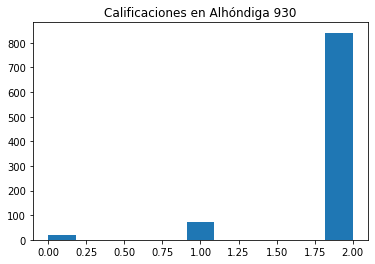

------------------------------
PUNTO 2
------------------------------
---------------Word Cloud---------------


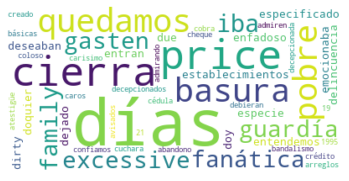

------------------------------
PUNTO 3
------------------------------
---------------Analisis LSA---------------
------------OPINIONES HOMBRES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
historia       0.365338 -0.037178  0.136641     0.365338
lugar          0.364184 -0.042822  0.551647     0.364184
méxico         0.258178 -0.024618 -0.028227     0.258178
independencia  0.236245 -0.023481 -0.132762     0.236245
museo          0.224350 -0.016132 -0.276837     0.224350
guanajuato     0.185769  0.062836 -0.011974     0.185769
visitar        0.157002 -0.015209  0.228407     0.157002
si             0.156928 -0.015344 -0.131883     0.156928
visita         0.152746 -0.009156 -0.145806     0.152746
bien           0.132578 -0.017243 -0.031574     0.132578

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
history       0.020736  0.339049 -0.007789     0.020736     0.339049
mexican       0.013961  0.238237  0.011110     0.013961     0.238237
museum        0.015207  0.234174 -0.010343     0.015207     0.234174
independence  0.016133  0.232197  0.006039     0.016133     0.232197
place         0.012029  0.227189  0.011548     0.012029     0.227189
building      0.013519  0.210732  0.019385     0.013519     0.210732
spanish       0.010237  0.185988  0.005483     0.010237     0.185988
great         0.010058  0.161390  0.009482     0.010058     0.161390
mexico        0.045799  0.148156 -0.033750     0.045799     0.148156
well          0.008797  0.147000  0.008310     0.008797     0.147000

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
lugar          0.364184 -0.042822  0.551647     0.364184     0.042822   
museo          0.224350 -0.016132 -0.276837     0.224350     0.016132   
visitar        0.157002 -0.015209  0.228407     0.157002     0.015209   
edificio       0.106412 -0.011043 -0.178102     0.106412     0.011043   
interesante    0.084072 -0.004614 -0.152188     0.084072     0.004614   
visita         0.152746 -0.009156 -0.145806     0.152746     0.009156   
historia       0.365338 -0.037178  0.136641     0.365338     0.037178   
independencia  0.236245 -0.023481 -0.132762     0.236245     0.023481   
si             0.156928 -0.015344 -0.131883     0.156928     0.015344   
ciudad         0.127037 -0.012300  0.120040     0.127037     0.012300   

               abs_topic_3  
lugar             0.551647  
museo             0.276837  
visitar           0.228407  
edificio          0.178102  
interesante       0.152188  
visita            0.145806  
historia          0.136641  
independencia     0.132762  
si                0.131883  
ciudad            0.120040

------------OPINIONES MUJERES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
historia       0.392180 -0.028575  0.167563     0.392180
lugar          0.347143 -0.027315  0.359151     0.347143
museo          0.239764 -0.016444 -0.249338     0.239764
méxico         0.204059 -0.013259  0.114507     0.204059
guanajuato     0.196577  0.077457  0.123218     0.196577
independencia  0.151405 -0.007866 -0.068427     0.151405
conocer        0.151364 -0.007494  0.275336     0.151364
si             0.132717 -0.004886 -0.159039     0.132717
visitar        0.131267 -0.008678  0.104699     0.131267
edificio       0.128826 -0.014626 -0.198241     0.128826

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
history      0.014781  0.387798 -0.001574     0.014781     0.387798
museum       0.009543  0.260333 -0.004858     0.009543     0.260333
mexican      0.007698  0.236809 -0.001827     0.007698     0.236809
building     0.007410  0.226400 -0.002214     0.007410     0.226400
spanish      0.007722  0.195268 -0.010866     0.007722     0.195268
place        0.005817  0.183923  0.004347     0.005817     0.183923
well         0.005976  0.175664 -0.014777     0.005976     0.175664
mexico       0.043489  0.157491  0.026393     0.043489     0.157491
visit        0.006872  0.151334  0.005240     0.006872     0.151334
interesting  0.004851  0.149204 -0.003593     0.004851     0.149204

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
lugar       0.347143 -0.027315  0.359151     0.347143     0.027315   
conocer     0.151364 -0.007494  0.275336     0.151364     0.007494   
museo       0.239764 -0.016444 -0.249338     0.239764     0.016444   
salas       0.087686 -0.006376 -0.198534     0.087686     0.006376   
edificio    0.128826 -0.014626 -0.198241     0.128826     0.014626   
murales     0.093459 -0.010037 -0.186321     0.093459     0.010037   
bien        0.126734 -0.010857 -0.177239     0.126734     0.010857   
historia    0.392180 -0.028575  0.167563     0.392180     0.028575   
parte       0.122431 -0.006294  0.165267     0.122431     0.006294   
importante  0.092151 -0.006910  0.163760     0.092151     0.006910   

            abs_topic_3  
lugar          0.359151  
conocer        0.275336  
museo          0.249338  
salas          0.198534  
edificio       0.198241  
murales        0.186321  
bien           0.177239  
historia       0.167563  
parte          0.165267  
importante     0.163760

------------OPINIONES NACIONALES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
historia       0.353269  0.198890  0.038521     0.353269
lugar          0.345333  0.342340 -0.222398     0.345333
museo          0.231042 -0.224916  0.187937     0.231042
méxico         0.230689  0.203619  0.284677     0.230689
independencia  0.199355  0.047121  0.392690     0.199355
guanajuato     0.197898  0.087140 -0.168454     0.197898
si             0.159754 -0.172039 -0.297415     0.159754
visitar        0.150478  0.141609 -0.072651     0.150478
visita         0.139458 -0.080444 -0.128055     0.139458
bien           0.136532 -0.158206  0.174317     0.136532

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
lugar     0.345333  0.342340 -0.222398     0.345333     0.342340
pena      0.106310 -0.267802 -0.144782     0.106310     0.267802
vale      0.099145 -0.249547 -0.127341     0.099145     0.249547
museo     0.231042 -0.224916  0.187937     0.231042     0.224916
méxico    0.230689  0.203619  0.284677     0.230689     0.203619
conocer   0.133385  0.202932 -0.018605     0.133385     0.202932
historia  0.353269  0.198890  0.038521     0.353269     0.198890
edificio  0.110529 -0.188629  0.129868     0.110529     0.188629
si        0.159754 -0.172039 -0.297415     0.159754     0.172039
bien      0.136532 -0.158206  0.174317     0.136532     0.158206

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
independencia  0.199355  0.047121  0.392690     0.199355     0.047121   
si             0.159754 -0.172039 -0.297415     0.159754     0.172039   
méxico         0.230689  0.203619  0.284677     0.230689     0.203619   
lugar          0.345333  0.342340 -0.222398     0.345333     0.342340   
museo          0.231042 -0.224916  0.187937     0.231042     0.224916   
bien           0.136532 -0.158206  0.174317     0.136532     0.158206   
guanajuato     0.197898  0.087140 -0.168454     0.197898     0.087140   
ir             0.076081  0.000465 -0.162071     0.076081     0.000465   
ciudad         0.105398  0.093428 -0.149978     0.105398     0.093428   
vas            0.059549 -0.051191 -0.148557     0.059549     0.051191   

               abs_topic_3  
independencia     0.392690  
si                0.297415  
méxico            0.284677  
lugar             0.222398  
museo             0.187937  
bien              0.174317  
guanajuato        0.168454  
ir                0.162071  
ciudad            0.149978  
vas               0.148557

------------OPINIONES INTERNACIONALES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
history       0.297066 -0.024403  0.178718     0.297066
mexican       0.227555 -0.022402  0.072765     0.227555
museum        0.225333 -0.018840  0.210883     0.225333
building      0.199478 -0.015270 -0.161337     0.199478
independence  0.185917 -0.007049 -0.149555     0.185917
place         0.184204 -0.027454  0.350194     0.184204
spanish       0.182449 -0.017978 -0.113375     0.182449
well          0.162131 -0.016664  0.010134     0.162131
mexico        0.151625  0.032199  0.084101     0.151625
murals        0.144883 -0.014906 -0.120124     0.144883

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
historia       0.020078  0.442095  0.044176     0.020078     0.442095
lugar          0.014517  0.334307  0.071312     0.014517     0.334307
méxico         0.016846  0.276030 -0.018881     0.016846     0.276030
museo          0.016394  0.242955 -0.052136     0.016394     0.242955
independencia  0.011207  0.224782 -0.014218     0.011207     0.224782
guanajuato     0.102831  0.164612 -0.118484     0.102831     0.164612
edificio       0.007051  0.156317 -0.006084     0.007051     0.156317
conocer        0.006834  0.124213 -0.002659     0.006834     0.124213
ciudad         0.006665  0.121235 -0.012429     0.006665     0.121235
bien           0.004702  0.115653  0.019661     0.004702     0.115653

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
place         0.184204 -0.027454  0.350194     0.184204     0.027454   
museum        0.225333 -0.018840  0.210883     0.225333     0.018840   
art           0.083954 -0.003686 -0.194810     0.083954     0.003686   
history       0.297066 -0.024403  0.178718     0.297066     0.024403   
really        0.072779 -0.009411  0.177498     0.072779     0.009411   
learn         0.102934 -0.009364  0.175360     0.102934     0.009364   
lot           0.073223 -0.010613  0.169354     0.073223     0.010613   
see           0.121394 -0.009163  0.164020     0.121394     0.009163   
building      0.199478 -0.015270 -0.161337     0.199478     0.015270   
independence  0.185917 -0.007049 -0.149555     0.185917     0.007049   

              abs_topic_3  
place            0.350194  
museum           0.210883  
art              0.194810  
history          0.178718  
really           0.177498  
learn            0.175360  
lot              0.169354  
see              0.164020  
building         0.161337  
independence     0.149555

------------OPINIONES JOVENES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
historia       0.369362 -0.021558 -0.057382     0.369362
lugar          0.365567 -0.025362 -0.540902     0.365567
museo          0.260413 -0.016143  0.343764     0.260413
méxico         0.206415 -0.014532  0.136502     0.206415
guanajuato     0.205790  0.079410 -0.081554     0.205790
independencia  0.176359 -0.013543  0.220270     0.176359
visitar        0.139381 -0.005440 -0.208171     0.139381
si             0.133966 -0.007664  0.003354     0.133966
visita         0.130959 -0.008409 -0.027353     0.130959
interesante    0.128341 -0.006358  0.049756     0.128341

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
history       0.011591  0.390040  0.004718     0.011591     0.390040
museum        0.010808  0.319384  0.005101     0.010808     0.319384
place         0.006992  0.227551  0.003457     0.006992     0.227551
mexican       0.006367  0.224707  0.003569     0.006367     0.224707
independence  0.007537  0.213140  0.005970     0.007537     0.213140
mexico        0.041711  0.179013 -0.032195     0.041711     0.179013
building      0.005522  0.172231  0.005396     0.005522     0.172231
spanish       0.004152  0.167299  0.003291     0.004152     0.167299
visit         0.005620  0.160863  0.001229     0.005620     0.160863
see           0.005487  0.141909  0.006315     0.005487     0.141909

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
lugar          0.365567 -0.025362 -0.540902     0.365567     0.025362   
museo          0.260413 -0.016143  0.343764     0.260413     0.016143   
independencia  0.176359 -0.013543  0.220270     0.176359     0.013543   
salas          0.096472 -0.010477  0.211068     0.096472     0.010477   
visitar        0.139381 -0.005440 -0.208171     0.139381     0.005440   
edificio       0.113493 -0.016789  0.203958     0.113493     0.016789   
murales        0.108516 -0.010515  0.183986     0.108516     0.010515   
méxico         0.206415 -0.014532  0.136502     0.206415     0.014532   
exposiciones   0.052708 -0.006949  0.114842     0.052708     0.006949   
lleno          0.091734 -0.010225 -0.113514     0.091734     0.010225   

               abs_topic_3  
lugar             0.540902  
museo             0.343764  
independencia     0.220270  
salas             0.211068  
visitar           0.208171  
edificio          0.203958  
murales           0.183986  
méxico            0.136502  
exposiciones      0.114842  
lleno             0.113514

------------OPINIONES MAYORES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
historia       0.394207 -0.070834 -0.116458     0.394207
lugar          0.321502 -0.061233 -0.119330     0.321502
méxico         0.309567 -0.060059 -0.297884     0.309567
independencia  0.220270 -0.038381 -0.186466     0.220270
museo          0.201705 -0.032185  0.103119     0.201705
guanajuato     0.165257  0.048670  0.205826     0.165257
visitar        0.164075 -0.030783 -0.093495     0.164075
bien           0.155630 -0.031213 -0.053509     0.155630
ciudad         0.155553 -0.024765  0.089394     0.155553
conocer        0.150848 -0.024566  0.000843     0.150848

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
history       0.043910  0.297288 -0.011495     0.043910     0.297288
mexican       0.034015  0.239057 -0.016006     0.034015     0.239057
building      0.033829  0.229357 -0.015308     0.033829     0.229357
independence  0.031146  0.196056  0.017504     0.031146     0.196056
museum        0.027975  0.195118  0.001067     0.027975     0.195118
spanish       0.026663  0.174421  0.015831     0.026663     0.174421
well          0.021029  0.158071 -0.053782     0.021029     0.158071
place         0.019559  0.153743 -0.063927     0.019559     0.153743
murals        0.019744  0.146330 -0.019037     0.019744     0.146330
exhibits      0.019368  0.144040 -0.039164     0.019368     0.144040

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
si             0.142818 -0.020568  0.298663     0.142818     0.020568   
méxico         0.309567 -0.060059 -0.297884     0.309567     0.060059   
visita         0.098727 -0.012202  0.293343     0.098727     0.012202   
ir             0.079122 -0.011723  0.229282     0.079122     0.011723   
obligada       0.058379 -0.004698  0.216406     0.058379     0.004698   
guanajuato     0.165257  0.048670  0.205826     0.165257     0.048670   
vas            0.069499 -0.009105  0.198384     0.069499     0.009105   
independencia  0.220270 -0.038381 -0.186466     0.220270     0.038381   
pena           0.073240 -0.012842  0.147246     0.073240     0.012842   
vale           0.073512 -0.014003  0.131817     0.073512     0.014003   

               abs_topic_3  
si                0.298663  
méxico            0.297884  
visita            0.293343  
ir                0.229282  
obligada          0.216406  
guanajuato        0.205826  
vas               0.198384  
independencia     0.186466  
pena              0.147246  
vale              0.131817

------------------------------
PUNTO 4
------------------------------
---------------Word Cloud Uni, Bi, Tri---------------


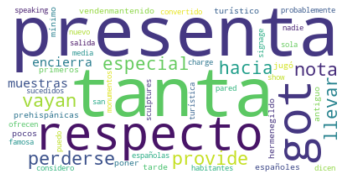

------------------------------
PUNTO 5
------------------------------
---------------Dispersion Plot---------------


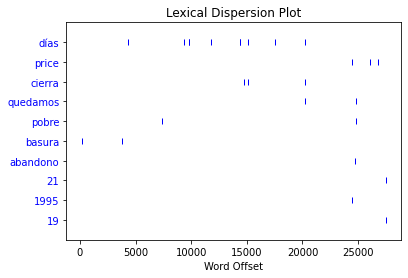

------------------------------
PUNTO 6
------------------------------
---------------Graficación libre---------------


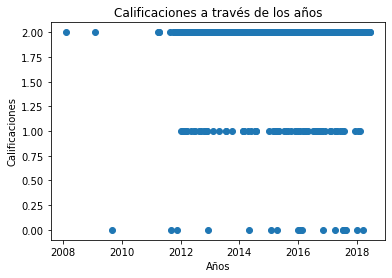

--------------------------------------------------------------------------------
TEATRO JUÁREZ 1,010
--------------------------------------------------------------------------------
------------------------------
PUNTO 1
------------------------------
---------------Estadísticas---------------
PROMEDIO y DESVIACIÓN ESTÁNDAR DE CALIFICACIÓN POR LUGAR
promedio:  1.9712871287128713
desviación estandar:  0.17282546204011567
LONGITUD PROMEDIO y DESVIACIÓN ESTÁNDAR DE OPINIONES POR LUGAR
promedio:  239.88811881188118
desviación estandar:  151.62908873928734


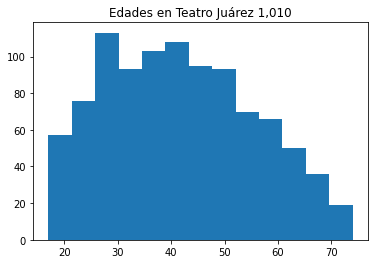

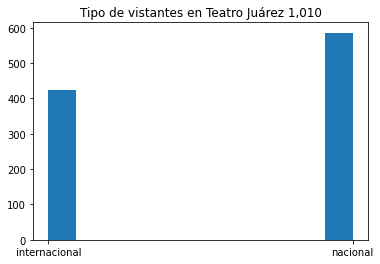

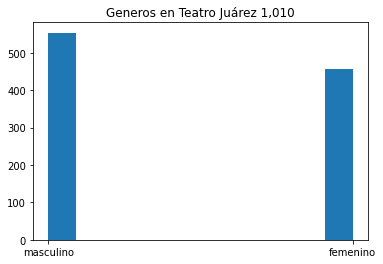

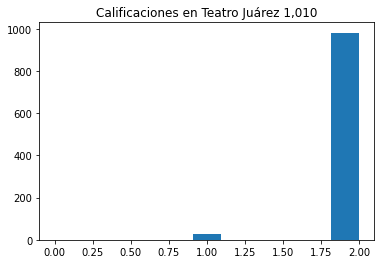

------------------------------
PUNTO 2
------------------------------
---------------Word Cloud---------------


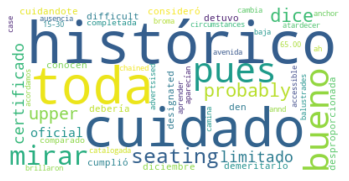

------------------------------
PUNTO 3
------------------------------
---------------Analisis LSA---------------
------------OPINIONES HOMBRES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
teatro        0.350322 -0.014412 -0.195763     0.350322
lugar         0.297233 -0.066463  0.542750     0.297233
guanajuato    0.219408  0.091961  0.220447     0.219408
ciudad        0.187537 -0.036589 -0.044328     0.187537
arquitectura  0.186939 -0.040660  0.001017     0.186939
hermoso       0.183337 -0.034379 -0.108913     0.183337
visitar       0.175160 -0.026105  0.266082     0.175160
historia      0.154926 -0.034354 -0.077658     0.154926
interior      0.141223  0.055024 -0.148669     0.141223
si            0.140838 -0.023151  0.033771     0.140838

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
theater    0.032689  0.284748  0.005902     0.032689     0.284748
inside     0.023054  0.244861  0.007286     0.023054     0.244861
beautiful  0.023052  0.242311 -0.009903     0.023052     0.242311
see        0.021120  0.215533  0.012931     0.021120     0.215533
theatre    0.018206  0.199425  0.008248     0.018206     0.199425
building   0.018794  0.177026 -0.008296     0.018794     0.177026
place      0.017758  0.161037  0.007068     0.017758     0.161037
great      0.013850  0.134373  0.009165     0.013850     0.134373
visit      0.012473  0.129953 -0.010956     0.012473     0.129953
worth      0.013064  0.129331 -0.014181     0.013064     0.129331

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
lugar       0.297233 -0.066463  0.542750     0.297233     0.066463   
visitar     0.175160 -0.026105  0.266082     0.175160     0.026105   
guanajuato  0.219408  0.091961  0.220447     0.219408     0.091961   
vale        0.138658 -0.029130 -0.206902     0.138658     0.029130   
teatro      0.350322 -0.014412 -0.195763     0.350322     0.014412   
pena        0.138158 -0.028255 -0.191938     0.138158     0.028255   
méxico      0.109907 -0.019784 -0.156111     0.109907     0.019784   
interior    0.141223  0.055024 -0.148669     0.141223     0.055024   
centro      0.099453 -0.000144  0.145032     0.099453     0.000144   
dentro      0.124090 -0.024566 -0.115654     0.124090     0.024566   

            abs_topic_3  
lugar          0.542750  
visitar        0.266082  
guanajuato     0.220447  
vale           0.206902  
teatro         0.195763  
pena           0.191938  
méxico         0.156111  
interior       0.148669  
centro         0.145032  
dentro         0.115654

------------OPINIONES MUJERES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
teatro        0.307248  0.005746  0.075139     0.307248
lugar         0.300220 -0.037305 -0.420172     0.300220
hermoso       0.209695 -0.016107 -0.025009     0.209695
guanajuato    0.203744  0.062192 -0.147171     0.203744
historia      0.196901 -0.017263 -0.164059     0.196901
pena          0.195813 -0.024663  0.393188     0.195813
vale          0.178618 -0.022954  0.358302     0.178618
arquitectura  0.169058 -0.010252 -0.199083     0.169058
dentro        0.157782 -0.018736  0.090147     0.157782
si            0.137084 -0.012716  0.101025     0.137084

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
beautiful    0.011422  0.286621  0.002817     0.011422     0.286621
see          0.010078  0.277485  0.005286     0.010078     0.277485
theater      0.010911  0.271730 -0.005105     0.010911     0.271730
inside       0.007741  0.190021  0.005139     0.007741     0.190021
go           0.007932  0.183538  0.006160     0.007932     0.183538
theatre      0.008183  0.183423  0.001780     0.008183     0.183423
building     0.007876  0.181279  0.004195     0.007876     0.181279
worth        0.006593  0.164918  0.006962     0.006593     0.164918
time         0.006012  0.142245  0.001078     0.006012     0.142245
performance  0.005719  0.141507  0.007953     0.005719     0.141507

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
lugar         0.300220 -0.037305 -0.420172     0.300220     0.037305   
pena          0.195813 -0.024663  0.393188     0.195813     0.024663   
vale          0.178618 -0.022954  0.358302     0.178618     0.022954   
arquitectura  0.169058 -0.010252 -0.199083     0.169058     0.010252   
historia      0.196901 -0.017263 -0.164059     0.196901     0.017263   
guanajuato    0.203744  0.062192 -0.147171     0.203744     0.062192   
visitar       0.130380 -0.013800 -0.140297     0.130380     0.013800   
conocerlo     0.076168 -0.011503  0.134367     0.076168     0.011503   
entrar        0.115266 -0.011756  0.124270     0.115266     0.011756   
bien          0.103685 -0.016803  0.111508     0.103685     0.016803   

              abs_topic_3  
lugar            0.420172  
pena             0.393188  
vale             0.358302  
arquitectura     0.199083  
historia         0.164059  
guanajuato       0.147171  
visitar          0.140297  
conocerlo        0.134367  
entrar           0.124270  
bien             0.111508

------------OPINIONES NACIONALES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
lugar         0.315007 -0.359905  0.442494     0.315007
teatro        0.303432  0.065005 -0.160865     0.303432
guanajuato    0.216251 -0.239922 -0.165030     0.216251
hermoso       0.197701  0.094933  0.027452     0.197701
historia      0.188117 -0.095451  0.318795     0.188117
arquitectura  0.168550 -0.104451  0.023053     0.168550
dentro        0.166281  0.112771 -0.060176     0.166281
pena          0.159345  0.426924  0.155930     0.159345
vale          0.156054  0.426963  0.156498     0.156054
visitar       0.155053 -0.188318  0.060310     0.155053

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
vale        0.156054  0.426963  0.156498     0.156054     0.426963
pena        0.159345  0.426924  0.155930     0.159345     0.426924
lugar       0.315007 -0.359905  0.442494     0.315007     0.359905
guanajuato  0.216251 -0.239922 -0.165030     0.216251     0.239922
visitar     0.155053 -0.188318  0.060310     0.155053     0.188318
entrar      0.090988  0.165712  0.019257     0.090988     0.165712
visitarlo   0.089677  0.126543 -0.014244     0.089677     0.126543
conocerlo   0.066241  0.117906 -0.013044     0.066241     0.117906
dentro      0.166281  0.112771 -0.060176     0.166281     0.112771
pagar       0.033783  0.106163  0.013892     0.033783     0.106163

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
lugar       0.315007 -0.359905  0.442494     0.315007     0.359905   
historia    0.188117 -0.095451  0.318795     0.188117     0.095451   
ciudad      0.154519 -0.055421 -0.265047     0.154519     0.055421   
guanajuato  0.216251 -0.239922 -0.165030     0.216251     0.239922   
teatro      0.303432  0.065005 -0.160865     0.303432     0.065005   
vale        0.156054  0.426963  0.156498     0.156054     0.426963   
pena        0.159345  0.426924  0.155930     0.159345     0.426924   
lleno       0.066392 -0.060574  0.135773     0.066392     0.060574   
juárez      0.086402 -0.036135 -0.133572     0.086402     0.036135   
excelente   0.095516 -0.070710  0.115693     0.095516     0.070710   

            abs_topic_3  
lugar          0.442494  
historia       0.318795  
ciudad         0.265047  
guanajuato     0.165030  
teatro         0.160865  
vale           0.156498  
pena           0.155930  
lleno          0.135773  
juárez         0.133572  
excelente      0.115693

------------OPINIONES INTERNACIONALES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
theater     0.241779 -0.069992 -0.223262     0.241779
beautiful   0.241421 -0.074613  0.127664     0.241421
see         0.219476 -0.070118 -0.038534     0.219476
inside      0.198689 -0.062199 -0.014593     0.198689
theatre     0.196837 -0.062318  0.635112     0.196837
building    0.171842 -0.049858 -0.087989     0.171842
worth       0.152478 -0.046256  0.016670     0.152478
guanajuato  0.149618  0.145489 -0.080828     0.149618
go          0.141822 -0.045679 -0.010743     0.141822
great       0.129740 -0.039751  0.015703     0.129740

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
teatro        0.128240  0.378605  0.008667     0.128240     0.378605
lugar         0.043412  0.213831 -0.013139     0.043412     0.213831
arquitectura  0.041379  0.189787  0.021756     0.041379     0.189787
hermoso       0.042621  0.186545 -0.093727     0.042621     0.186545
pena          0.038150  0.183171  0.058679     0.038150     0.183171
ciudad        0.038409  0.180360  0.048950     0.038409     0.180360
visita        0.041700  0.172267 -0.006291     0.041700     0.172267
vale          0.032986  0.161652  0.054419     0.032986     0.161652
visitar       0.030498  0.146941 -0.018934     0.030498     0.146941
guanajuato    0.149618  0.145489 -0.080828     0.149618     0.145489

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
theatre     0.196837 -0.062318  0.635112     0.196837     0.062318   
theater     0.241779 -0.069992 -0.223262     0.241779     0.069992   
night       0.115568 -0.037387 -0.186272     0.115568     0.037387   
beautiful   0.241421 -0.074613  0.127664     0.241421     0.074613   
nice        0.080897 -0.027114 -0.107059     0.080897     0.027114   
small       0.061736 -0.018833  0.107007     0.061736     0.018833   
fee         0.076118 -0.020743  0.105704     0.076118     0.020743   
absolutely  0.045435 -0.015789  0.103909     0.045435     0.015789   
make        0.040702 -0.012734  0.095672     0.040702     0.012734   
spanish     0.050180 -0.018114  0.094257     0.050180     0.018114   

            abs_topic_3  
theatre        0.635112  
theater        0.223262  
night          0.186272  
beautiful      0.127664  
nice           0.107059  
small          0.107007  
fee            0.105704  
absolutely     0.103909  
make           0.095672  
spanish        0.094257

------------OPINIONES JOVENES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
teatro        0.343142  0.008781  0.087562     0.343142
lugar         0.291596 -0.033181 -0.343177     0.291596
hermoso       0.215002 -0.027873  0.074900     0.215002
guanajuato    0.201529  0.097009 -0.230119     0.201529
pena          0.169012 -0.027910  0.394341     0.169012
ciudad        0.165434 -0.016078 -0.056271     0.165434
historia      0.163131 -0.023989  0.030792     0.163131
vale          0.162485 -0.028224  0.382431     0.162485
dentro        0.159494 -0.027479  0.086109     0.159494
arquitectura  0.153524 -0.017463 -0.169398     0.153524

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
theater       0.016215  0.282388  0.010085     0.016215     0.282388
beautiful     0.011427  0.263071  0.019190     0.011427     0.263071
see           0.011564  0.255436  0.002310     0.011564     0.255436
inside        0.008555  0.212340  0.015945     0.008555     0.212340
worth         0.008641  0.178774  0.025428     0.008641     0.178774
go            0.007957  0.172785 -0.001025     0.007957     0.172785
time          0.006983  0.146980  0.005088     0.006983     0.146980
great         0.008512  0.145905 -0.007288     0.008512     0.145905
architecture  0.005888  0.144087  0.011114     0.005888     0.144087
building      0.008197  0.142857  0.011062     0.008197     0.142857

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
pena          0.169012 -0.027910  0.394341     0.169012     0.027910   
vale          0.162485 -0.028224  0.382431     0.162485     0.028224   
lugar         0.291596 -0.033181 -0.343177     0.291596     0.033181   
visitar       0.137176 -0.008172 -0.232871     0.137176     0.008172   
guanajuato    0.201529  0.097009 -0.230119     0.201529     0.097009   
duda          0.087014 -0.001677 -0.188732     0.087014     0.001677   
arquitectura  0.153524 -0.017463 -0.169398     0.153524     0.017463   
entrar        0.098128 -0.017613  0.111687     0.098128     0.017613   
obligado      0.035816  0.001340 -0.107765     0.035816     0.001340   
visitarlo     0.085854 -0.007345  0.103666     0.085854     0.007345   

              abs_topic_3  
pena             0.394341  
vale             0.382431  
lugar            0.343177  
visitar          0.232871  
guanajuato       0.230119  
duda             0.188732  
arquitectura     0.169398  
entrar           0.111687  
obligado         0.107765  
visitarlo        0.103666

------------OPINIONES MAYORES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
teatro        0.337997 -0.045713 -0.118923     0.337997
lugar         0.225835 -0.060074  0.038740     0.225835
guanajuato    0.220259  0.062653 -0.065289     0.220259
visitar       0.198093 -0.046459  0.127267     0.198093
arquitectura  0.188480 -0.038720  0.032186     0.188480
pena          0.184067 -0.041918  0.354203     0.184067
vale          0.181617 -0.041380  0.379646     0.181617
hermoso       0.172264 -0.033707  0.015783     0.172264
ciudad        0.166993 -0.035277 -0.303078     0.166993
historia      0.164610 -0.045769  0.111977     0.164610

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
beautiful  0.035238  0.254466  0.008129     0.035238     0.254466
theater    0.039681  0.250103  0.002758     0.039681     0.250103
theatre    0.030743  0.241818  0.021051     0.030743     0.241818
see        0.031596  0.229149  0.020890     0.031596     0.229149
building   0.029875  0.214846  0.009939     0.029875     0.214846
inside     0.024039  0.171220  0.017573     0.024039     0.171220
well       0.023162  0.165832 -0.000339     0.023162     0.165832
worth      0.021781  0.155992  0.012170     0.021781     0.155992
go         0.020259  0.140648  0.000101     0.020259     0.140648
great      0.019542  0.133023  0.003668     0.019542     0.133023

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  abs_topic_3
vale     0.181617 -0.041380  0.379646     0.181617     0.041380     0.379646
pena     0.184067 -0.041918  0.354203     0.184067     0.041918     0.354203
ciudad   0.166993 -0.035277 -0.303078     0.166993     0.035277     0.303078
méxico   0.129176 -0.036925  0.166509     0.129176     0.036925     0.166509
centro   0.113584 -0.006076 -0.143432     0.113584     0.006076     0.143432
época    0.071952 -0.022379  0.131644     0.071952     0.022379     0.131644
visitar  0.198093 -0.046459  0.127267     0.198093     0.046459     0.127267
sitio    0.053867 -0.016751  0.126027     0.053867     0.016751     0.126027
teatro   0.337997 -0.045713 -0.118923     0.337997     0.045713     0.118923
teatros  0.057548 -0.014497  0.116793     0.057548     0.014497     0.116793

------------------------------
PUNTO 4
------------------------------
---------------Word Cloud Uni, Bi, Tri---------------


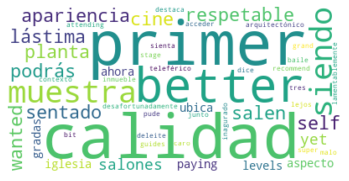

------------------------------
PUNTO 5
------------------------------
---------------Dispersion Plot---------------


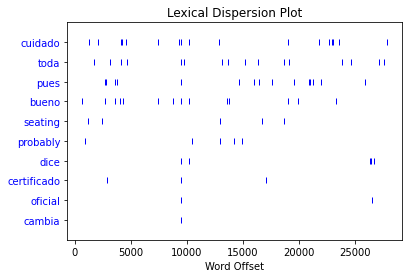

------------------------------
PUNTO 6
------------------------------
---------------Graficación libre---------------


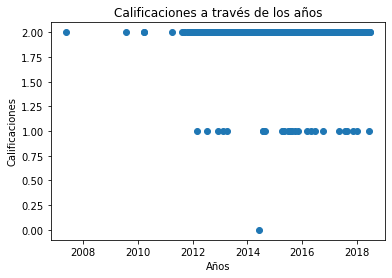

--------------------------------------------------------------------------------
JARDÍN DE LA UNIÓN 1,134
--------------------------------------------------------------------------------
------------------------------
PUNTO 1
------------------------------
---------------Estadísticas---------------
PROMEDIO y DESVIACIÓN ESTÁNDAR DE CALIFICACIÓN POR LUGAR
promedio:  1.9409171075837743
desviación estandar:  0.2537921322492758
LONGITUD PROMEDIO y DESVIACIÓN ESTÁNDAR DE OPINIONES POR LUGAR
promedio:  248.66666666666666
desviación estandar:  203.01561177490422


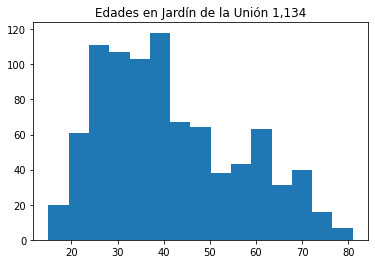

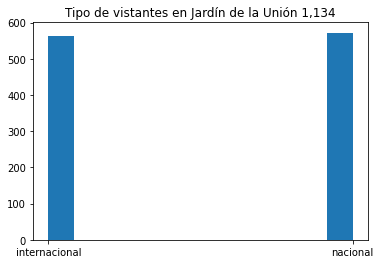

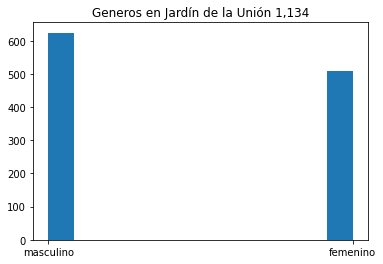

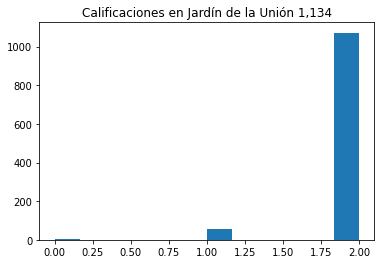

------------------------------
PUNTO 2
------------------------------
---------------Word Cloud---------------


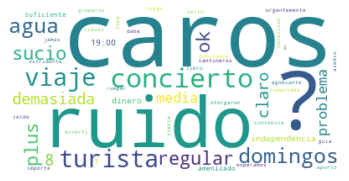

------------------------------
PUNTO 3
------------------------------
---------------Analisis LSA---------------
------------OPINIONES HOMBRES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
lugar         0.270504 -0.202171 -0.253978     0.270504
restaurantes  0.231657 -0.162832  0.058893     0.231657
guanajuato    0.202966 -0.028409  0.190196     0.202966
teatro        0.188981 -0.059712  0.194972     0.188981
ciudad        0.159942 -0.112098  0.250549     0.159942
jardín        0.150323 -0.095027  0.126371     0.150323
plaza         0.137513  0.024261  0.243091     0.137513
jardin        0.137447  0.123017  0.026634     0.137447
place         0.131909  0.229672 -0.104884     0.131909
restaurants   0.129160  0.201396 -0.014137     0.129160

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
place         0.131909  0.229672 -0.104884     0.131909     0.229672
people        0.123566  0.209767 -0.011050     0.123566     0.209767
lugar         0.270504 -0.202171 -0.253978     0.270504     0.202171
restaurants   0.129160  0.201396 -0.014137     0.129160     0.201396
great         0.108033  0.191264 -0.097074     0.108033     0.191264
restaurantes  0.231657 -0.162832  0.058893     0.231657     0.162832
music         0.088609  0.150225 -0.039822     0.088609     0.150225
one           0.078495  0.133634  0.027424     0.078495     0.133634
around        0.073508  0.126955 -0.028938     0.073508     0.126955
jardin        0.137447  0.123017  0.026634     0.137447     0.123017

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
buen        0.093569 -0.071915 -0.263238     0.093569     0.071915   
lugar       0.270504 -0.202171 -0.253978     0.270504     0.202171   
ciudad      0.159942 -0.112098  0.250549     0.159942     0.112098   
plaza       0.137513  0.024261  0.243091     0.137513     0.024261   
ambiente    0.115697 -0.086408 -0.195564     0.115697     0.086408   
teatro      0.188981 -0.059712  0.194972     0.188981     0.059712   
centro      0.126293 -0.075641  0.194591     0.126293     0.075641   
guanajuato  0.202966 -0.028409  0.190196     0.202966     0.028409   
comer       0.101735 -0.074862 -0.186056     0.101735     0.074862   
frente      0.090112 -0.059520  0.157652     0.090112     0.059520   

            abs_topic_3  
buen           0.263238  
lugar          0.253978  
ciudad         0.250549  
plaza          0.243091  
ambiente       0.195564  
teatro         0.194972  
centro         0.194591  
guanajuato     0.190196  
comer          0.186056  
frente         0.157652

------------OPINIONES MUJERES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
lugar         0.258926 -0.161385 -0.117382     0.258926
restaurantes  0.237914 -0.141910  0.139821     0.237914
guanajuato    0.195759 -0.016578  0.059909     0.195759
jardín        0.181142 -0.104165  0.144032     0.181142
teatro        0.178928 -0.040055  0.304999     0.178928
gente         0.139621 -0.083340 -0.115984     0.139621
place         0.134761  0.270306 -0.025661     0.134761
disfrutar     0.131205 -0.080195 -0.124836     0.131205
música        0.126528 -0.079795 -0.126830     0.126528
alrededor     0.126333 -0.074853  0.100966     0.126333

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
place         0.134761  0.270306 -0.025661     0.134761     0.270306
people        0.125221  0.252166 -0.003074     0.125221     0.252166
restaurants   0.126198  0.229083  0.008177     0.126198     0.229083
music         0.092223  0.188744 -0.027506     0.092223     0.188744
great         0.083523  0.166426  0.002569     0.083523     0.166426
lugar         0.258926 -0.161385 -0.117382     0.258926     0.161385
watch         0.079531  0.158343 -0.008864     0.079531     0.158343
around        0.072285  0.144397 -0.037677     0.072285     0.144397
sit           0.070807  0.143862 -0.010831     0.070807     0.143862
restaurantes  0.237914 -0.141910  0.139821     0.237914     0.141910

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  abs_topic_3
teatro    0.178928 -0.040055  0.304999     0.178928     0.040055     0.304999
juárez    0.103517 -0.053159  0.228327     0.103517     0.053159     0.228327
pasar     0.103488 -0.063263 -0.191608     0.103488     0.063263     0.191608
ciudad    0.109903 -0.064542  0.179441     0.109903     0.064542     0.179441
frente    0.075596 -0.041948  0.179130     0.075596     0.041948     0.179130
escuchar  0.089810 -0.054486 -0.165575     0.089810     0.054486     0.165575
plaza     0.114439  0.048423  0.158990     0.114439     0.048423     0.158990
buen      0.084819 -0.054591 -0.153009     0.084819     0.054591     0.153009
musica    0.061188 -0.036924 -0.149986     0.061188     0.036924     0.149986
centro    0.104842 -0.051860  0.144665     0.104842     0.051860     0.144665

------------OPINIONES NACIONALES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
lugar         0.300340 -0.071816 -0.020522     0.300340
restaurantes  0.251694  0.031345 -0.054095     0.251694
guanajuato    0.202279  0.180045 -0.081668     0.202279
jardín        0.196056  0.073739 -0.093888     0.196056
teatro        0.188809  0.248768 -0.139303     0.188809
ciudad        0.147477  0.148664 -0.162757     0.147477
pasar         0.137082 -0.214772  0.161264     0.137082
música        0.135056 -0.076966  0.040184     0.135056
gente         0.133488 -0.055005  0.011242     0.133488
disfrutar     0.132475 -0.095043  0.062174     0.132475

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
teatro       0.188809  0.248768 -0.139303     0.188809     0.248768
pasar        0.137082 -0.214772  0.161264     0.137082     0.214772
restaurants  0.020549  0.199441  0.254157     0.020549     0.199441
plaza        0.070502  0.187719  0.076763     0.070502     0.187719
place        0.005280  0.182322  0.254861     0.005280     0.182322
buen         0.114067 -0.180209  0.162623     0.114067     0.180209
guanajuato   0.202279  0.180045 -0.081668     0.202279     0.180045
people       0.007178  0.177247  0.229880     0.007178     0.177247
juarez       0.096745  0.157706 -0.003066     0.096745     0.157706
ciudad       0.147477  0.148664 -0.162757     0.147477     0.148664

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
place        0.005280  0.182322  0.254861     0.005280     0.182322   
restaurants  0.020549  0.199441  0.254157     0.020549     0.199441   
people       0.007178  0.177247  0.229880     0.007178     0.177247   
music        0.004688  0.133723  0.186234     0.004688     0.133723   
great        0.004301  0.130841  0.176632     0.004301     0.130841   
ciudad       0.147477  0.148664 -0.162757     0.147477     0.148664   
buen         0.114067 -0.180209  0.162623     0.114067     0.180209   
pasar        0.137082 -0.214772  0.161264     0.137082     0.214772   
juárez       0.122424  0.140922 -0.155065     0.122424     0.140922   
teatro       0.188809  0.248768 -0.139303     0.188809     0.248768   

             abs_topic_3  
place           0.254861  
restaurants     0.254157  
people          0.229880  
music           0.186234  
great           0.176632  
ciudad          0.162757  
buen            0.162623  
pasar           0.161264  
juárez          0.155065  
teatro          0.139303

------------OPINIONES INTERNACIONALES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
place        0.261053 -0.045672  0.357542     0.261053
people       0.234741 -0.039030  0.169622     0.234741
restaurants  0.227757 -0.025429 -0.213482     0.227757
great        0.192695 -0.036295  0.428353     0.192695
music        0.177990 -0.029063  0.067061     0.177990
jardin       0.172310  0.008751 -0.153419     0.172310
watch        0.157154 -0.028588  0.157960     0.157154
around       0.155256 -0.027444 -0.076602     0.155256
one          0.142872 -0.022773 -0.109943     0.142872
sit          0.137650 -0.027154  0.046243     0.137650

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
restaurantes  0.017341  0.320373  0.014682     0.017341     0.320373
lugar         0.013611  0.304965  0.052956     0.013611     0.304965
ciudad        0.011778  0.211177  0.011084     0.011778     0.211177
plaza         0.099301  0.174999  0.022666     0.099301     0.174999
teatro        0.072105  0.171658 -0.078428     0.072105     0.171658
noche         0.010275  0.160601  0.011447     0.010275     0.160601
centro        0.019170  0.153528 -0.004962     0.019170     0.153528
jardín        0.016520  0.152429 -0.012592     0.016520     0.152429
gente         0.007573  0.151201  0.026265     0.007573     0.151201
guanajuato    0.112773  0.135945 -0.063364     0.112773     0.135945

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
great        0.192695 -0.036295  0.428353     0.192695     0.036295   
place        0.261053 -0.045672  0.357542     0.261053     0.045672   
area         0.100376 -0.008379 -0.250950     0.100376     0.008379   
restaurants  0.227757 -0.025429 -0.213482     0.227757     0.025429   
many         0.117030 -0.007861 -0.193688     0.117030     0.007861   
people       0.234741 -0.039030  0.169622     0.234741     0.039030   
watch        0.157154 -0.028588  0.157960     0.157154     0.028588   
jardin       0.172310  0.008751 -0.153419     0.172310     0.008751   
night        0.129582 -0.015534  0.150317     0.129582     0.015534   
watching     0.110822 -0.020000  0.122905     0.110822     0.020000   

             abs_topic_3  
great           0.428353  
place           0.357542  
area            0.250950  
restaurants     0.213482  
many            0.193688  
people          0.169622  
watch           0.157960  
jardin          0.153419  
night           0.150317  
watching        0.122905

------------OPINIONES JOVENES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
lugar         0.302430 -0.064072 -0.226368     0.302430
restaurantes  0.263711 -0.037851  0.126577     0.263711
teatro        0.200885  0.029587  0.276234     0.200885
guanajuato    0.187435  0.045787  0.038901     0.187435
jardín        0.185282 -0.013278  0.121744     0.185282
ciudad        0.157825 -0.019091  0.180132     0.157825
disfrutar     0.136659 -0.031165 -0.259435     0.136659
música        0.133242 -0.028794 -0.126959     0.133242
puedes        0.132048 -0.020917 -0.135147     0.132048
centro        0.127214 -0.008903  0.199424     0.127214

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
place        0.020709  0.290424 -0.022256     0.020709     0.290424
restaurants  0.029637  0.265681 -0.010178     0.029637     0.265681
people       0.018062  0.213151 -0.006266     0.018062     0.213151
music        0.013189  0.176118 -0.027451     0.013189     0.176118
jardin       0.076779  0.175792 -0.020546     0.076779     0.175792
great        0.012961  0.175109 -0.015216     0.012961     0.175109
night        0.012795  0.161104 -0.027793     0.012795     0.161104
watch        0.013024  0.159198 -0.008655     0.013024     0.159198
beautiful    0.015980  0.155028  0.004345     0.015980     0.155028
around       0.010847  0.149100 -0.028229     0.010847     0.149100

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  abs_topic_3
teatro     0.200885  0.029587  0.276234     0.200885     0.029587     0.276234
disfrutar  0.136659 -0.031165 -0.259435     0.136659     0.031165     0.259435
lugar      0.302430 -0.064072 -0.226368     0.302430     0.064072     0.226368
centro     0.127214 -0.008903  0.199424     0.127214     0.008903     0.199424
frente     0.086685 -0.003202  0.198796     0.086685     0.003202     0.198796
musica     0.053200 -0.008913 -0.180209     0.053200     0.008913     0.180209
ciudad     0.157825 -0.019091  0.180132     0.157825     0.019091     0.180132
juarez     0.103838  0.072792  0.171799     0.103838     0.072792     0.171799
plaza      0.096972  0.070766  0.161484     0.096972     0.070766     0.161484
escuchar   0.084231 -0.016866 -0.152482     0.084231     0.016866     0.152482

------------OPINIONES MAYORES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
place        0.269678 -0.070444  0.255905     0.269678
restaurants  0.230243 -0.045204 -0.030656     0.230243
people       0.226582 -0.054369  0.017606     0.226582
one          0.185550 -0.044793 -0.140330     0.185550
great        0.181047 -0.046231  0.182786     0.181047
jardin       0.179126  0.011123 -0.080003     0.179126
around       0.164333 -0.039250  0.017724     0.164333
plaza        0.137549  0.102355 -0.084688     0.137549
trees        0.136521 -0.038491  0.017115     0.136521
lovely       0.129174 -0.034758  0.051971     0.129174

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
lugar         0.039018  0.329500  0.322950     0.039018     0.329500
restaurantes  0.037784  0.270657 -0.074019     0.037784     0.270657
ciudad        0.030633  0.202076 -0.110645     0.030633     0.202076
teatro        0.098349  0.172733 -0.246632     0.098349     0.172733
jardín        0.029032  0.164128 -0.053520     0.029032     0.164128
guanajuato    0.116548  0.150797  0.011995     0.116548     0.150797
gente         0.018757  0.148300  0.040903     0.018757     0.148300
juárez        0.021220  0.139800 -0.146263     0.021220     0.139800
bares         0.017767  0.132495 -0.022399     0.017767     0.132495
música        0.014466  0.127676 -0.032470     0.014466     0.127676

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  abs_topic_3
lugar     0.039018  0.329500  0.322950     0.039018     0.329500     0.322950
place     0.269678 -0.070444  0.255905     0.269678     0.070444     0.255905
teatro    0.098349  0.172733 -0.246632     0.098349     0.172733     0.246632
great     0.181047 -0.046231  0.182786     0.181047     0.046231     0.182786
juarez    0.093423  0.040667 -0.157209     0.093423     0.040667     0.157209
juárez    0.021220  0.139800 -0.146263     0.021220     0.139800     0.146263
one       0.185550 -0.044793 -0.140330     0.185550     0.044793     0.140330
personas  0.010803  0.087448  0.134310     0.010803     0.087448     0.134310
diego     0.029305  0.037004 -0.119364     0.029305     0.037004     0.119364
san       0.032729  0.035690 -0.117163     0.032729     0.035690     0.117163

------------------------------
PUNTO 4
------------------------------
---------------Word Cloud Uni, Bi, Tri---------------


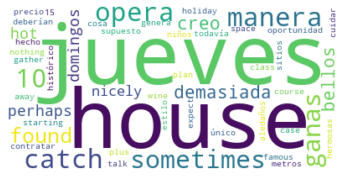

------------------------------
PUNTO 5
------------------------------
---------------Dispersion Plot---------------


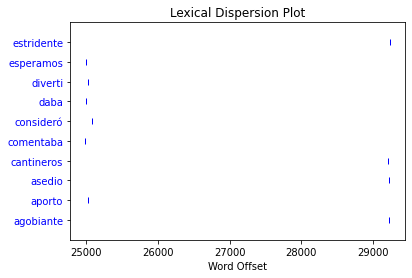

------------------------------
PUNTO 6
------------------------------
---------------Graficación libre---------------


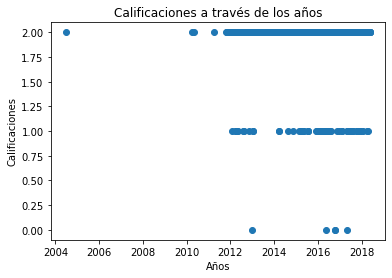

--------------------------------------------------------------------------------
CALLEJÓN DEL BESO 1,360
--------------------------------------------------------------------------------
------------------------------
PUNTO 1
------------------------------
---------------Estadísticas---------------
PROMEDIO y DESVIACIÓN ESTÁNDAR DE CALIFICACIÓN POR LUGAR
promedio:  1.6433823529411764
desviación estandar:  0.5866407616403697
LONGITUD PROMEDIO y DESVIACIÓN ESTÁNDAR DE OPINIONES POR LUGAR
promedio:  251.1169117647059
desviación estandar:  179.93977426086497


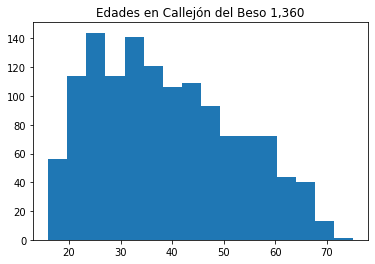

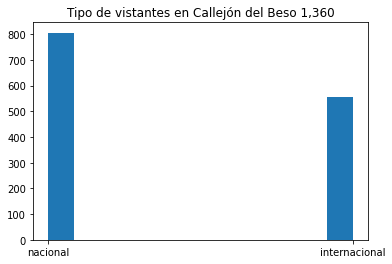

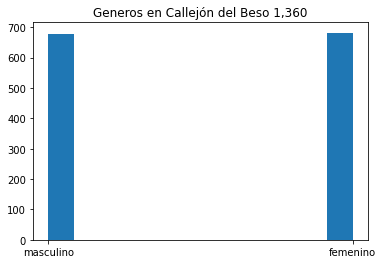

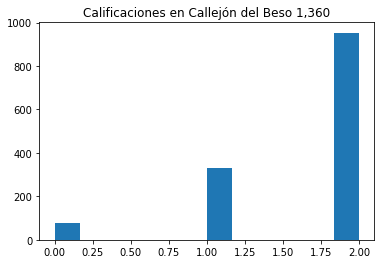

------------------------------
PUNTO 2
------------------------------
---------------Word Cloud---------------


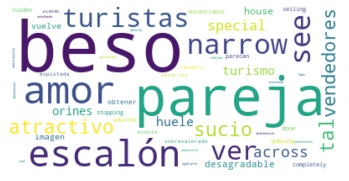

------------------------------
PUNTO 3
------------------------------
---------------Analisis LSA---------------
------------OPINIONES HOMBRES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
lugar       0.307042 -0.038686 -0.409140     0.307042
callejón    0.275952 -0.005363  0.278095     0.275952
beso        0.274758  0.040849  0.439871     0.274758
si          0.236575 -0.020783 -0.010888     0.236575
historia    0.226130 -0.023471 -0.097102     0.226130
guanajuato  0.214761  0.131132  0.015706     0.214761
pareja      0.213625 -0.022549  0.090411     0.213625
leyenda     0.179239 -0.017717  0.145763     0.179239
foto        0.159496 -0.018988 -0.132751     0.159496
ir          0.152838 -0.016455 -0.132154     0.152838

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
alley       0.009876  0.297527 -0.016142     0.009876     0.297527
kiss        0.008764  0.249114 -0.001494     0.008764     0.249114
one         0.006993  0.232557 -0.008648     0.006993     0.232557
story       0.008219  0.229217 -0.009631     0.008219     0.229217
place       0.008058  0.208493 -0.008172     0.008058     0.208493
take        0.005327  0.197873 -0.016330     0.005327     0.197873
see         0.005457  0.149949 -0.005185     0.005457     0.149949
go          0.005048  0.142803 -0.011169     0.005048     0.142803
picture     0.004256  0.131565 -0.002584     0.004256     0.131565
guanajuato  0.214761  0.131132  0.015706     0.214761     0.131132

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  abs_topic_3
beso      0.274758  0.040849  0.439871     0.274758     0.040849     0.439871
lugar     0.307042 -0.038686 -0.409140     0.307042     0.038686     0.409140
callejón  0.275952 -0.005363  0.278095     0.275952     0.005363     0.278095
escalón   0.096847 -0.009227  0.220190     0.096847     0.009227     0.220190
visitar   0.126875 -0.011016 -0.207653     0.126875     0.011016     0.207653
tercer    0.073387 -0.007786  0.180873     0.073387     0.007786     0.180873
gente     0.109111 -0.016558 -0.150085     0.109111     0.016558     0.150085
leyenda   0.179239 -0.017717  0.145763     0.179239     0.017717     0.145763
suerte    0.060018 -0.007837  0.140208     0.060018     0.007837     0.140208
foto      0.159496 -0.018988 -0.132751     0.159496     0.018988     0.132751

------------OPINIONES MUJERES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
lugar       0.292000 -0.028491  0.528200     0.292000
callejón    0.262158 -0.003588 -0.295718     0.262158
si          0.256567 -0.021089 -0.047812     0.256567
beso        0.235740  0.029504 -0.288094     0.235740
foto        0.199089 -0.024026  0.013971     0.199089
guanajuato  0.196573  0.117342  0.027518     0.196573
pareja      0.191589 -0.018322 -0.089951     0.191589
historia    0.189144 -0.022785  0.116093     0.189144
leyenda     0.180035 -0.016449 -0.155247     0.180035
ir          0.162093 -0.005431 -0.065511     0.162093

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
kiss      0.010061  0.292115  0.018161     0.010061     0.292115
alley     0.006127  0.269086  0.021064     0.006127     0.269086
story     0.005998  0.240301  0.011129     0.005998     0.240301
go        0.007196  0.192516  0.008874     0.007196     0.192516
place     0.007301  0.189177 -0.000840     0.007301     0.189177
one       0.007275  0.178838  0.012117     0.007275     0.178838
take      0.005122  0.166964 -0.001593     0.005122     0.166964
visit     0.005944  0.135852 -0.006945     0.005944     0.135852
romantic  0.004959  0.133845  0.001917     0.004959     0.133845
get       0.002867  0.131326  0.005872     0.002867     0.131326

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  abs_topic_3
lugar     0.292000 -0.028491  0.528200     0.292000     0.028491     0.528200
callejón  0.262158 -0.003588 -0.295718     0.262158     0.003588     0.295718
beso      0.235740  0.029504 -0.288094     0.235740     0.029504     0.288094
visitar   0.140481 -0.008246  0.206652     0.140481     0.008246     0.206652
gente     0.121719 -0.016784  0.202059     0.121719     0.016784     0.202059
leyenda   0.180035 -0.016449 -0.155247     0.180035     0.016449     0.155247
escalón   0.092996 -0.012470 -0.141987     0.092996     0.012470     0.141987
tercer    0.078775 -0.010508 -0.134400     0.078775     0.010508     0.134400
suerte    0.078395 -0.008341 -0.130305     0.078395     0.008341     0.130305
mucha     0.067638 -0.008001  0.117140     0.067638     0.008001     0.117140

------------OPINIONES NACIONALES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
lugar       0.285517 -0.388044 -0.299590     0.285517
callejón    0.260527  0.203249  0.053873     0.260527
beso        0.253737  0.363493 -0.063125     0.253737
si          0.242632  0.104600 -0.166450     0.242632
pareja      0.208121  0.146214 -0.108780     0.208121
guanajuato  0.206925 -0.039924 -0.229096     0.206925
historia    0.196141 -0.097368 -0.019860     0.196141
foto        0.183726 -0.134585  0.343119     0.183726
leyenda     0.179211  0.122626  0.134054     0.179211
ir          0.164551  0.073488  0.026657     0.164551

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
lugar     0.285517 -0.388044 -0.299590     0.285517     0.388044
beso      0.253737  0.363493 -0.063125     0.253737     0.363493
gente     0.117075 -0.248376  0.191942     0.117075     0.248376
escalón   0.100026  0.224302  0.110642     0.100026     0.224302
tercer    0.079268  0.204057  0.090974     0.079268     0.204057
callejón  0.260527  0.203249  0.053873     0.260527     0.203249
suerte    0.067608  0.171154  0.066152     0.067608     0.171154
visitar   0.133585 -0.162951 -0.167784     0.133585     0.162951
pareja    0.208121  0.146214 -0.108780     0.208121     0.146214
mucha     0.066444 -0.141899  0.050633     0.066444     0.141899

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
foto        0.183726 -0.134585  0.343119     0.183726     0.134585   
lugar       0.285517 -0.388044 -0.299590     0.285517     0.388044   
guanajuato  0.206925 -0.039924 -0.229096     0.206925     0.039924   
vas         0.153647  0.100218 -0.208922     0.153647     0.100218   
balcón      0.091640  0.011740  0.199431     0.091640     0.011740   
gente       0.117075 -0.248376  0.191942     0.117075     0.248376   
visitar     0.133585 -0.162951 -0.167784     0.133585     0.162951   
si          0.242632  0.104600 -0.166450     0.242632     0.104600   
subir       0.061591  0.005409  0.148347     0.061591     0.005409   
tomarte     0.083381 -0.049939  0.148317     0.083381     0.049939   

            abs_topic_3  
foto           0.343119  
lugar          0.299590  
guanajuato     0.229096  
vas            0.208922  
balcón         0.199431  
gente          0.191942  
visitar        0.167784  
si             0.166450  
subir          0.148347  
tomarte        0.148317

------------OPINIONES INTERNACIONALES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
alley       0.250122 -0.121291 -0.137739     0.250122
kiss        0.238372 -0.107243 -0.022542     0.238372
story       0.208455 -0.097499 -0.026265     0.208455
guanajuato  0.197368  0.119498  0.034593     0.197368
one         0.186713 -0.086477 -0.025072     0.186713
take        0.169931 -0.081798  0.038388     0.169931
place       0.162959 -0.070458  0.066847     0.162959
go          0.158603 -0.071232  0.002373     0.158603
beso        0.150560  0.218208  0.319133     0.150560
picture     0.130142 -0.062399  0.004514     0.130142

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
lugar     0.118278  0.306611 -0.316979     0.118278     0.306611
callejón  0.115528  0.266967  0.212561     0.115528     0.266967
si        0.089717  0.227488 -0.189054     0.089717     0.227488
historia  0.088965  0.223606  0.011673     0.088965     0.223606
beso      0.150560  0.218208  0.319133     0.150560     0.218208
pareja    0.064703  0.170673 -0.039347     0.064703     0.170673
leyenda   0.066333  0.167943  0.196643     0.066333     0.167943
foto      0.055111  0.147136 -0.150946     0.055111     0.147136
ciudad    0.053185  0.128702  0.136637     0.053185     0.128702
alley     0.250122 -0.121291 -0.137739     0.250122     0.121291

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  abs_topic_3
beso      0.150560  0.218208  0.319133     0.150560     0.218208     0.319133
lugar     0.118278  0.306611 -0.316979     0.118278     0.306611     0.316979
ir        0.048113  0.120987 -0.222291     0.048113     0.120987     0.222291
callejón  0.115528  0.266967  0.212561     0.115528     0.266967     0.212561
leyenda   0.066333  0.167943  0.196643     0.066333     0.167943     0.196643
si        0.089717  0.227488 -0.189054     0.089717     0.227488     0.189054
visitar   0.044992  0.114147 -0.179662     0.044992     0.114147     0.179662
foto      0.055111  0.147136 -0.150946     0.055111     0.147136     0.150946
alley     0.250122 -0.121291 -0.137739     0.250122     0.121291     0.137739
ciudad    0.053185  0.128702  0.136637     0.053185     0.128702     0.136637

------------OPINIONES JOVENES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
lugar       0.301806 -0.036647 -0.427652     0.301806
callejón    0.274963 -0.002060  0.239016     0.274963
si          0.247897 -0.013002  0.079806     0.247897
beso        0.239256  0.043408  0.313146     0.239256
historia    0.214133 -0.021468 -0.157653     0.214133
pareja      0.207628 -0.019975  0.158192     0.207628
guanajuato  0.195757  0.134152  0.087473     0.195757
foto        0.194832 -0.026151 -0.126004     0.194832
ir          0.172287 -0.009898  0.108846     0.172287
leyenda     0.169818 -0.013167  0.112462     0.169818

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
alley       0.006100  0.259607 -0.021594     0.006100     0.259607
kiss        0.006759  0.239423 -0.015201     0.006759     0.239423
place       0.007006  0.230271 -0.011420     0.007006     0.230271
go          0.007159  0.217682 -0.015286     0.007159     0.217682
story       0.006314  0.199659 -0.009905     0.006314     0.199659
take        0.005432  0.196350 -0.019942     0.005432     0.196350
one         0.003940  0.164852 -0.016607     0.003940     0.164852
visit       0.004849  0.144741 -0.010105     0.004849     0.144741
must        0.006638  0.137647 -0.000824     0.006638     0.137647
guanajuato  0.195757  0.134152  0.087473     0.195757     0.134152

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  abs_topic_3
lugar     0.301806 -0.036647 -0.427652     0.301806     0.036647     0.427652
beso      0.239256  0.043408  0.313146     0.239256     0.043408     0.313146
gente     0.120124 -0.018819 -0.260459     0.120124     0.018819     0.260459
callejón  0.274963 -0.002060  0.239016     0.274963     0.002060     0.239016
pareja    0.207628 -0.019975  0.158192     0.207628     0.019975     0.158192
historia  0.214133 -0.021468 -0.157653     0.214133     0.021468     0.157653
visita    0.096774  0.001184  0.156577     0.096774     0.001184     0.156577
escalón   0.086053 -0.005496  0.154981     0.086053     0.005496     0.154981
vas       0.138812 -0.003369  0.141407     0.138812     0.003369     0.141407
tercer    0.065804 -0.005468  0.133021     0.065804     0.005468     0.133021

------------OPINIONES MAYORES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
beso        0.298463  0.011686 -0.290124     0.298463
lugar       0.295807 -0.040228  0.262919     0.295807
callejón    0.276497 -0.021971 -0.242821     0.276497
leyenda     0.215020 -0.029885 -0.169611     0.215020
guanajuato  0.203848  0.110736  0.051340     0.203848
pareja      0.202976 -0.027495  0.095349     0.202976
historia    0.192978 -0.026704 -0.022739     0.192978
si          0.191516 -0.029902  0.096432     0.191516
visitar     0.161381 -0.021338  0.276399     0.161381
foto        0.139064 -0.024579  0.172663     0.139064

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
kiss       0.025878  0.318670 -0.003145     0.025878     0.318670
alley      0.022134  0.296638  0.001677     0.022134     0.296638
story      0.017562  0.240221 -0.003959     0.017562     0.240221
one        0.021129  0.239027  0.009589     0.021129     0.239027
place      0.015816  0.165747 -0.009597     0.015816     0.165747
narrow     0.011010  0.155960  0.009853     0.011010     0.155960
take       0.007964  0.143029  0.008502     0.007964     0.143029
balconies  0.008452  0.134481  0.003259     0.008452     0.134481
picture    0.007921  0.129863 -0.005002     0.007921     0.129863
visit      0.010567  0.118541 -0.000948     0.010567     0.118541

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  abs_topic_3
beso      0.298463  0.011686 -0.290124     0.298463     0.011686     0.290124
visitar   0.161381 -0.021338  0.276399     0.161381     0.021338     0.276399
lugar     0.295807 -0.040228  0.262919     0.295807     0.040228     0.262919
callejón  0.276497 -0.021971 -0.242821     0.276497     0.021971     0.242821
puedes    0.094220 -0.013123  0.229843     0.094220     0.013123     0.229843
dejar     0.083550 -0.008454  0.194838     0.083550     0.008454     0.194838
bonito    0.077057 -0.014078  0.176372     0.077057     0.014078     0.176372
foto      0.139064 -0.024579  0.172663     0.139064     0.024579     0.172663
leyenda   0.215020 -0.029885 -0.169611     0.215020     0.029885     0.169611
fotos     0.074972 -0.012408  0.153774     0.074972     0.012408     0.153774

------------------------------
PUNTO 4
------------------------------
---------------Word Cloud Uni, Bi, Tri---------------


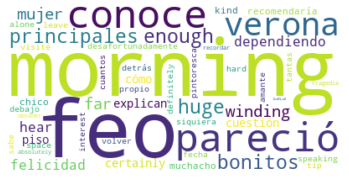

------------------------------
PUNTO 5
------------------------------
---------------Dispersion Plot---------------


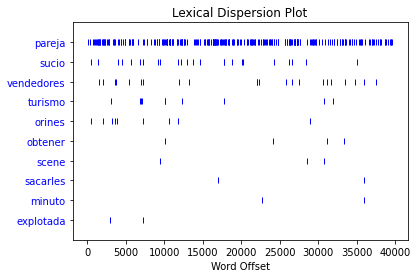

------------------------------
PUNTO 6
------------------------------
---------------Graficación libre---------------


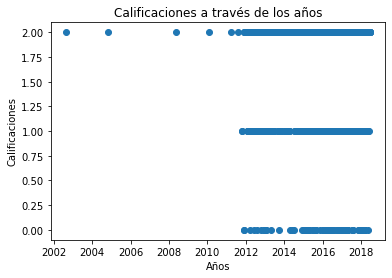

--------------------------------------------------------------------------------
MONUMENTO PÍPILA 1,620
--------------------------------------------------------------------------------
------------------------------
PUNTO 1
------------------------------
---------------Estadísticas---------------
PROMEDIO y DESVIACIÓN ESTÁNDAR DE CALIFICACIÓN POR LUGAR
promedio:  1.8537037037037036
desviación estandar:  0.40086925439859444
LONGITUD PROMEDIO y DESVIACIÓN ESTÁNDAR DE OPINIONES POR LUGAR
promedio:  264.4327160493827
desviación estandar:  199.16532568283935


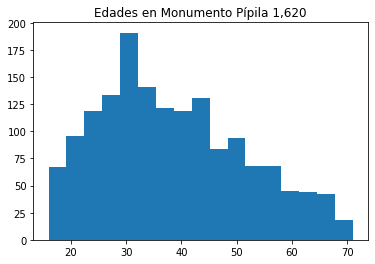

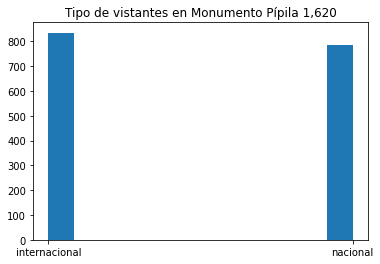

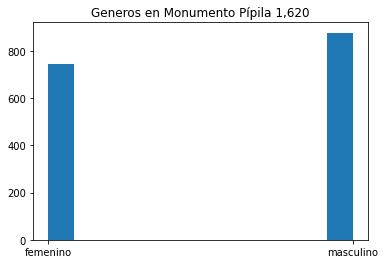

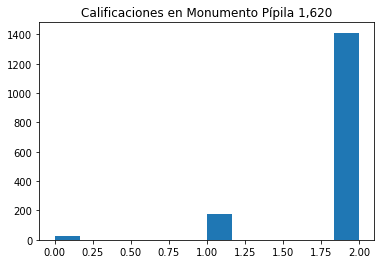

------------------------------
PUNTO 2
------------------------------
---------------Word Cloud---------------


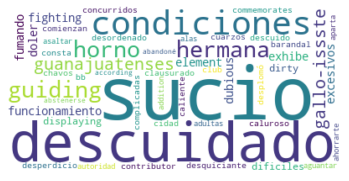

------------------------------
PUNTO 3
------------------------------
---------------Analisis LSA---------------
------------OPINIONES HOMBRES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
ciudad      0.344892 -0.065438 -0.098948     0.344892
vista       0.315432 -0.051649 -0.029658     0.315432
guanajuato  0.266420  0.086042 -0.213771     0.266420
monumento   0.222269 -0.033448  0.078445     0.222269
lugar       0.214561 -0.039604 -0.404063     0.214561
subir       0.182710 -0.025010  0.309140     0.182710
puedes      0.166315 -0.026223 -0.059268     0.166315
pípila      0.157626 -0.021060  0.053547     0.157626
si          0.149820 -0.023189 -0.009231     0.149820
puede       0.138111 -0.023181  0.045137     0.138111

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
view       0.032842  0.338199 -0.012605     0.032842     0.338199
city       0.028720  0.311383 -0.010703     0.028720     0.311383
monument   0.024257  0.253386 -0.004521     0.024257     0.253386
take       0.022815  0.244066 -0.009855     0.022815     0.244066
top        0.017234  0.196612  0.011242     0.017234     0.196612
great      0.016596  0.170201 -0.008580     0.016596     0.170201
funicular  0.136523  0.166823  0.157168     0.136523     0.166823
walk       0.015455  0.161930  0.004231     0.015455     0.161930
get        0.016089  0.152602 -0.007160     0.016089     0.152602
views      0.013875  0.150628  0.002117     0.013875     0.150628

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
lugar       0.214561 -0.039604 -0.404063     0.214561     0.039604   
vale        0.122689 -0.022594  0.357112     0.122689     0.022594   
pena        0.121002 -0.022193  0.350667     0.121002     0.022193   
subir       0.182710 -0.025010  0.309140     0.182710     0.025010   
guanajuato  0.266420  0.086042 -0.213771     0.266420     0.086042   
visitar     0.104270 -0.018167 -0.160016     0.104270     0.018167   
funicular   0.136523  0.166823  0.157168     0.136523     0.166823   
excelente   0.080230 -0.017387 -0.153587     0.080230     0.017387   
caminando   0.062729 -0.007554  0.121557     0.062729     0.007554   
hermosa     0.107743 -0.019615 -0.120864     0.107743     0.019615   

            abs_topic_3  
lugar          0.404063  
vale           0.357112  
pena           0.350667  
subir          0.309140  
guanajuato     0.213771  
visitar        0.160016  
funicular      0.157168  
excelente      0.153587  
caminando      0.121557  
hermosa        0.120864

------------OPINIONES MUJERES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
ciudad      0.341009 -0.048558 -0.139274     0.341009
vista       0.317517 -0.036072 -0.168101     0.317517
guanajuato  0.249213  0.079243 -0.079681     0.249213
monumento   0.246911 -0.028481 -0.381484     0.246911
lugar       0.223878 -0.036968 -0.068877     0.223878
puedes      0.202811 -0.026744  0.431381     0.202811
subir       0.180815 -0.019265  0.274462     0.180815
pípila      0.150750 -0.019197 -0.169683     0.150750
si          0.145013 -0.019593  0.110797     0.145013
toda        0.141291 -0.024136 -0.096210     0.141291

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
view      0.025471  0.373451 -0.015758     0.025471     0.373451
city      0.021024  0.323598 -0.018511     0.021024     0.323598
monument  0.016328  0.229436 -0.003122     0.016328     0.229436
take      0.014157  0.213699  0.002100     0.014157     0.213699
go        0.014686  0.206848 -0.015643     0.014686     0.206848
see       0.012505  0.174079  0.004929     0.012505     0.174079
great     0.010310  0.173992 -0.009630     0.010310     0.173992
get       0.011333  0.158091  0.004001     0.011333     0.158091
top       0.010864  0.152772  0.005632     0.010864     0.152772
walk      0.011275  0.146900  0.011734     0.011275     0.146900

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
puedes      0.202811 -0.026744  0.431381     0.202811     0.026744   
monumento   0.246911 -0.028481 -0.381484     0.246911     0.028481   
subir       0.180815 -0.019265  0.274462     0.180815     0.019265   
pípila      0.150750 -0.019197 -0.169683     0.150750     0.019197   
vista       0.317517 -0.036072 -0.168101     0.317517     0.036072   
historia    0.063504 -0.009223 -0.153177     0.063504     0.009223   
llegar      0.105130 -0.010792  0.150759     0.105130     0.010792   
teleférico  0.084136 -0.013018  0.148500     0.084136     0.013018   
tomar       0.099652 -0.009932  0.145139     0.099652     0.009932   
caminando   0.080897 -0.006834  0.142334     0.080897     0.006834   

            abs_topic_3  
puedes         0.431381  
monumento      0.381484  
subir          0.274462  
pípila         0.169683  
vista          0.168101  
historia       0.153177  
llegar         0.150759  
teleférico     0.148500  
tomar          0.145139  
caminando      0.142334

------------OPINIONES NACIONALES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
ciudad      0.308027  0.107073 -0.075288     0.308027
vista       0.294320  0.037468 -0.014783     0.294320
guanajuato  0.260533  0.177098  0.172914     0.260533
lugar       0.239472  0.422747  0.014912     0.239472
monumento   0.218677 -0.007918 -0.055882     0.218677
puedes      0.193514 -0.043091  0.040742     0.193514
subir       0.183775 -0.351251 -0.026130     0.183775
si          0.165591 -0.002243  0.056564     0.165591
pípila      0.152593 -0.021981 -0.019244     0.152593
funicular   0.138329 -0.228562  0.083766     0.138329

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
lugar       0.239472  0.422747  0.014912     0.239472     0.422747
subir       0.183775 -0.351251 -0.026130     0.183775     0.351251
vale        0.105805 -0.262834 -0.065394     0.105805     0.262834
pena        0.102965 -0.247345 -0.062523     0.102965     0.247345
funicular   0.138329 -0.228562  0.083766     0.138329     0.228562
guanajuato  0.260533  0.177098  0.172914     0.260533     0.177098
caminando   0.082675 -0.149509 -0.008601     0.082675     0.149509
toda        0.120935  0.137228 -0.059252     0.120935     0.137228
historia    0.084935  0.135773 -0.007311     0.084935     0.135773
visitar     0.101330  0.129935 -0.000293     0.101330     0.129935

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
city        0.004083 -0.017958  0.364275     0.004083     0.017958   
view        0.003938 -0.020253  0.339030     0.003938     0.020253   
go          0.002692 -0.009416  0.223503     0.002692     0.009416   
take        0.002549 -0.010793  0.196663     0.002549     0.010793   
get         0.002715 -0.013609  0.188127     0.002715     0.013609   
monument    0.003098 -0.014980  0.181172     0.003098     0.014980   
pipila      0.011898  0.000618  0.179736     0.011898     0.000618   
guanajuato  0.260533  0.177098  0.172914     0.260533     0.177098   
worth       0.001601 -0.005870  0.140542     0.001601     0.005870   
see         0.001261 -0.008360  0.133326     0.001261     0.008360   

            abs_topic_3  
city           0.364275  
view           0.339030  
go             0.223503  
take           0.196663  
get            0.188127  
monument       0.181172  
pipila         0.179736  
guanajuato     0.172914  
worth          0.140542  
see            0.133326

------------OPINIONES INTERNACIONALES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
view        0.268034 -0.202434  0.000853     0.268034
city        0.234344 -0.180483 -0.011252     0.234344
guanajuato  0.233492  0.114920  0.069950     0.233492
ciudad      0.214317  0.334398 -0.225153     0.214317
funicular   0.209538 -0.024516 -0.020380     0.209538
monument    0.194852 -0.148049 -0.007091     0.194852
vista       0.189242  0.281436 -0.108357     0.189242
take        0.186697 -0.143384 -0.013436     0.186697
monumento   0.147040  0.213785 -0.403514     0.147040
top         0.146099 -0.112346 -0.010921     0.146099

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
ciudad     0.214317  0.334398 -0.225153     0.214317     0.334398
vista      0.189242  0.281436 -0.108357     0.189242     0.281436
monumento  0.147040  0.213785 -0.403514     0.147040     0.213785
view       0.268034 -0.202434  0.000853     0.268034     0.202434
city       0.234344 -0.180483 -0.011252     0.234344     0.180483
lugar      0.093900  0.148536  0.074401     0.093900     0.148536
monument   0.194852 -0.148049 -0.007091     0.194852     0.148049
subir      0.098624  0.147200  0.168090     0.098624     0.147200
ver        0.095387  0.146104  0.279181     0.095387     0.146104
take       0.186697 -0.143384 -0.013436     0.186697     0.143384

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
monumento   0.147040  0.213785 -0.403514     0.147040     0.213785   
ver         0.095387  0.146104  0.279181     0.095387     0.146104   
paisaje     0.031047  0.050120  0.237806     0.031047     0.050120   
teleférico  0.043342  0.069763  0.230234     0.043342     0.069763   
ciudad      0.214317  0.334398 -0.225153     0.214317     0.334398   
noche       0.063794  0.098684  0.210670     0.063794     0.098684   
subir       0.098624  0.147200  0.168090     0.098624     0.147200   
día         0.039382  0.063278  0.162684     0.039382     0.063278   
puedes      0.091306  0.138621  0.148735     0.091306     0.138621   
ir          0.047324  0.071173  0.134186     0.047324     0.071173   

            abs_topic_3  
monumento      0.403514  
ver            0.279181  
paisaje        0.237806  
teleférico     0.230234  
ciudad         0.225153  
noche          0.210670  
subir          0.168090  
día            0.162684  
puedes         0.148735  
ir             0.134186

------------OPINIONES JOVENES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
ciudad      0.341547 -0.052776  0.129264     0.341547
vista       0.320518 -0.041532  0.143904     0.320518
guanajuato  0.256879  0.089588  0.203118     0.256879
monumento   0.236989 -0.026173 -0.015346     0.236989
lugar       0.211780 -0.034805  0.343625     0.211780
puedes      0.194876 -0.025722 -0.149992     0.194876
subir       0.192895 -0.018383 -0.396672     0.192895
si          0.155767 -0.020556 -0.130102     0.155767
pípila      0.145902 -0.013022  0.002173     0.145902
funicular   0.141133  0.160217 -0.220632     0.141133

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
view       0.022797  0.367265  0.038562     0.022797     0.367265
city       0.016495  0.290454  0.018178     0.016495     0.290454
monument   0.014727  0.233232  0.003482     0.014727     0.233232
take       0.012755  0.215825  0.002581     0.012755     0.215825
top        0.011335  0.189380  0.003947     0.011335     0.189380
great      0.010700  0.186277  0.005854     0.010700     0.186277
walk       0.011334  0.180323 -0.007267     0.011334     0.180323
funicular  0.141133  0.160217 -0.220632     0.141133     0.160217
get        0.010209  0.158124  0.006903     0.010209     0.158124
see        0.008987  0.147526  0.011741     0.008987     0.147526

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
subir       0.192895 -0.018383 -0.396672     0.192895     0.018383   
lugar       0.211780 -0.034805  0.343625     0.211780     0.034805   
funicular   0.141133  0.160217 -0.220632     0.141133     0.160217   
guanajuato  0.256879  0.089588  0.203118     0.256879     0.089588   
historia    0.077385 -0.010832  0.159508     0.077385     0.010832   
puedes      0.194876 -0.025722 -0.149992     0.194876     0.025722   
pena        0.097395 -0.013416 -0.145098     0.097395     0.013416   
vista       0.320518 -0.041532  0.143904     0.320518     0.041532   
toda        0.126865 -0.021893  0.140314     0.126865     0.021893   
vale        0.095582 -0.013196 -0.139717     0.095582     0.013196   

            abs_topic_3  
subir          0.396672  
lugar          0.343625  
funicular      0.220632  
guanajuato     0.203118  
historia       0.159508  
puedes         0.149992  
pena           0.145098  
vista          0.143904  
toda           0.140314  
vale           0.139717

------------OPINIONES MAYORES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
ciudad      0.352838 -0.132456 -0.100851     0.352838
vista       0.323559 -0.114342  0.019284     0.323559
monumento   0.255529 -0.086065 -0.201500     0.255529
guanajuato  0.251840  0.014460 -0.127209     0.251840
lugar       0.206645 -0.078861 -0.111229     0.206645
subir       0.160165 -0.055738  0.283345     0.160165
pípila      0.156625 -0.056120 -0.186239     0.156625
funicular   0.144204  0.145962  0.097977     0.144204
ver         0.129125 -0.047945 -0.055803     0.129125
puede       0.128131 -0.047495  0.023998     0.128131

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
view      0.085436  0.290605  0.013818     0.085436     0.290605
city      0.078891  0.272534  0.038410     0.078891     0.272534
take      0.074471  0.242956  0.000830     0.074471     0.242956
monument  0.072137  0.238347 -0.009890     0.072137     0.238347
top       0.050810  0.171874 -0.007114     0.050810     0.171874
great     0.050600  0.170347  0.000780     0.050600     0.170347
views     0.049979  0.169710  0.002817     0.049979     0.169710
get       0.045977  0.155479 -0.001570     0.045977     0.155479
see       0.047740  0.155182  0.001920     0.047740     0.155182
go        0.043731  0.148298 -0.008391     0.043731     0.148298

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
vale        0.110805 -0.042270  0.314208     0.110805     0.042270   
pena        0.109801 -0.041548  0.313921     0.109801     0.041548   
subir       0.160165 -0.055738  0.283345     0.160165     0.055738   
noche       0.113625 -0.043711  0.253716     0.113625     0.043711   
día         0.094569 -0.039415  0.246355     0.094569     0.039415   
monumento   0.255529 -0.086065 -0.201500     0.255529     0.086065   
pípila      0.156625 -0.056120 -0.186239     0.156625     0.056120   
arriba      0.068921 -0.024764  0.130301     0.068921     0.024764   
guanajuato  0.251840  0.014460 -0.127209     0.251840     0.014460   
parte       0.082275 -0.028231 -0.118068     0.082275     0.028231   

            abs_topic_3  
vale           0.314208  
pena           0.313921  
subir          0.283345  
noche          0.253716  
día            0.246355  
monumento      0.201500  
pípila         0.186239  
arriba         0.130301  
guanajuato     0.127209  
parte          0.118068

------------------------------
PUNTO 4
------------------------------
---------------Word Cloud Uni, Bi, Tri---------------


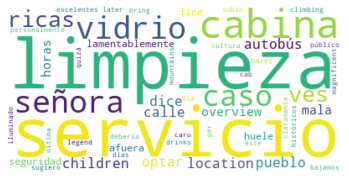

------------------------------
PUNTO 5
------------------------------
---------------Dispersion Plot---------------


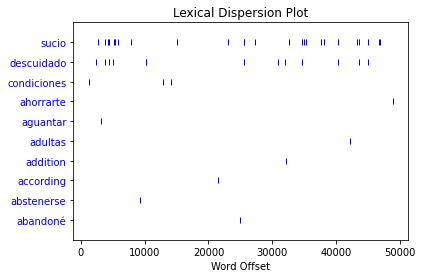

------------------------------
PUNTO 6
------------------------------
---------------Graficación libre---------------


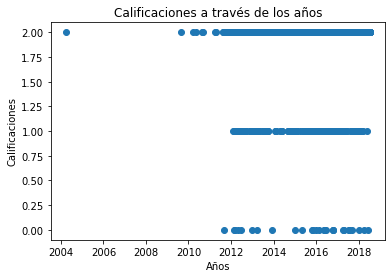

--------------------------------------------------------------------------------
MUSEO DE LAS MOMIAS 1,650
--------------------------------------------------------------------------------
------------------------------
PUNTO 1
------------------------------
---------------Estadísticas---------------
PROMEDIO y DESVIACIÓN ESTÁNDAR DE CALIFICACIÓN POR LUGAR
promedio:  1.4412121212121212
desviación estandar:  0.730627615533624
LONGITUD PROMEDIO y DESVIACIÓN ESTÁNDAR DE OPINIONES POR LUGAR
promedio:  327.65575757575755
desviación estandar:  259.9876272933737


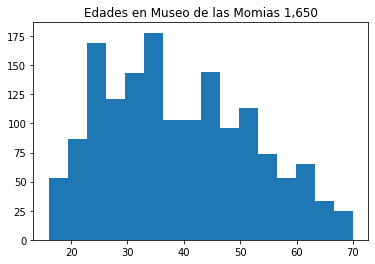

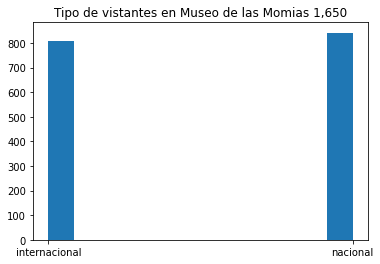

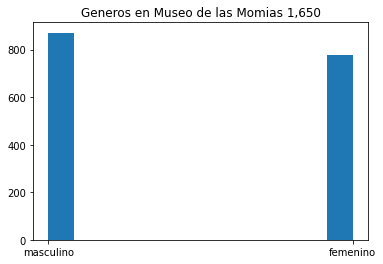

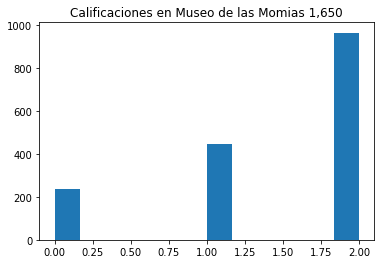

------------------------------
PUNTO 2
------------------------------
---------------Word Cloud---------------


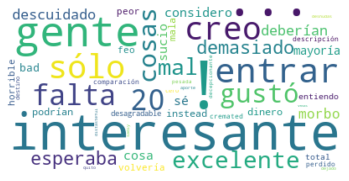

------------------------------
PUNTO 3
------------------------------
---------------Analisis LSA---------------
------------OPINIONES HOMBRES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
museo        0.341103 -0.042533 -0.197475     0.341103
momias       0.324035 -0.033000 -0.172370     0.324035
guanajuato   0.245908  0.067820  0.168729     0.245908
lugar        0.218039 -0.033598  0.529577     0.218039
si           0.196867 -0.028842  0.074398     0.196867
ver          0.165406 -0.026197 -0.138656     0.165406
visita       0.162166 -0.022750  0.166515     0.162166
interesante  0.139675 -0.022094 -0.106279     0.139675
ir           0.133017 -0.019021  0.141519     0.133017
cuerpos      0.129454 -0.019752 -0.320192     0.129454

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
museum       0.031224  0.312345 -0.031028     0.031224     0.312345
mummies      0.030660  0.292957 -0.000661     0.030660     0.292957
see          0.022235  0.216330 -0.003123     0.022235     0.216330
place        0.019051  0.181630  0.015743     0.019051     0.181630
interesting  0.016401  0.172976  0.006559     0.016401     0.172976
visit        0.019267  0.172567  0.002376     0.019267     0.172567
people       0.014848  0.161347  0.005072     0.014848     0.161347
bodies       0.014563  0.150617 -0.001743     0.014563     0.150617
one          0.016796  0.149006 -0.000859     0.016796     0.149006
like         0.013466  0.138041  0.007434     0.013466     0.138041

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
lugar       0.218039 -0.033598  0.529577     0.218039     0.033598   
cuerpos     0.129454 -0.019752 -0.320192     0.129454     0.019752   
museo       0.341103 -0.042533 -0.197475     0.341103     0.042533   
momias      0.324035 -0.033000 -0.172370     0.324035     0.033000   
guanajuato  0.245908  0.067820  0.168729     0.245908     0.067820   
visita      0.162166 -0.022750  0.166515     0.162166     0.022750   
visitar     0.115448 -0.015515  0.152235     0.115448     0.015515   
ir          0.133017 -0.019021  0.141519     0.133017     0.019021   
ver         0.165406 -0.026197 -0.138656     0.165406     0.026197   
obligada    0.072106 -0.009117  0.134728     0.072106     0.009117   

            abs_topic_3  
lugar          0.529577  
cuerpos        0.320192  
museo          0.197475  
momias         0.172370  
guanajuato     0.168729  
visita         0.166515  
visitar        0.152235  
ir             0.141519  
ver            0.138656  
obligada       0.134728

------------OPINIONES MUJERES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
museo        0.317849 -0.035826 -0.266719     0.317849
momias       0.314144 -0.032475 -0.095358     0.314144
si           0.213879 -0.025811  0.036673     0.213879
lugar        0.209388 -0.026464  0.638052     0.209388
guanajuato   0.204600  0.091535  0.048642     0.204600
ver          0.179622 -0.022949 -0.029288     0.179622
bien         0.173571 -0.024825  0.021584     0.173571
interesante  0.173282 -0.023469  0.013927     0.173282
visita       0.141648 -0.014545 -0.175522     0.141648
historia     0.121769 -0.015100  0.092730     0.121769

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
museum       0.030831  0.372500  0.030362     0.030831     0.372500
mummies      0.028327  0.340814  0.003054     0.028327     0.340814
see          0.021005  0.237926 -0.015059     0.021005     0.237926
interesting  0.015684  0.177059 -0.001229     0.015684     0.177059
place        0.011871  0.148681 -0.033938     0.011871     0.148681
bodies       0.011717  0.145195  0.014080     0.011717     0.145195
people       0.011359  0.144837  0.008749     0.011359     0.144837
visit        0.012168  0.133164  0.000505     0.012168     0.133164
like         0.009453  0.127267 -0.007880     0.009453     0.127267
one          0.010931  0.126960  0.007404     0.010931     0.126960

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  abs_topic_3
lugar      0.209388 -0.026464  0.638052     0.209388     0.026464     0.638052
museo      0.317849 -0.035826 -0.266719     0.317849     0.035826     0.266719
recorrido  0.112239 -0.013980 -0.182742     0.112239     0.013980     0.182742
visita     0.141648 -0.014545 -0.175522     0.141648     0.014545     0.175522
buen       0.043056 -0.004211  0.119472     0.043056     0.004211     0.119472
minutos    0.060551 -0.004665 -0.109903     0.060551     0.004665     0.109903
hacer      0.064161 -0.007138 -0.109327     0.064161     0.007138     0.109327
ir         0.118908 -0.013681  0.099733     0.118908     0.013681     0.099733
gente      0.105572 -0.012774  0.097896     0.105572     0.012774     0.097896
pequeño    0.057722 -0.006328 -0.096001     0.057722     0.006328     0.096001

------------OPINIONES NACIONALES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
museo        0.311177 -0.008624  0.174720     0.311177
momias       0.289207 -0.025256 -0.052314     0.289207
guanajuato   0.236330  0.175169 -0.062956     0.236330
lugar        0.221068 -0.026943 -0.507081     0.221068
si           0.216780 -0.003964 -0.024526     0.216780
ver          0.169700 -0.016168 -0.123246     0.169700
visita       0.156250  0.024069  0.038070     0.156250
interesante  0.154160 -0.029378 -0.075272     0.154160
ir           0.144508 -0.004604  0.074731     0.144508
bien         0.124881 -0.028527 -0.002755     0.124881

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
museum       0.005863  0.405524 -0.003110     0.005863     0.405524
see          0.006038  0.282146 -0.004653     0.006038     0.282146
mummies      0.002982  0.223853 -0.000218     0.002982     0.223853
visit        0.004036  0.194593 -0.004291     0.004036     0.194593
people       0.002704  0.192622 -0.002264     0.002704     0.192622
place        0.003128  0.192316 -0.004500     0.003128     0.192316
guanajuato   0.236330  0.175169 -0.062956     0.236330     0.175169
like         0.002081  0.157850 -0.003346     0.002081     0.157850
interesting  0.001925  0.143112 -0.001094     0.001925     0.143112
one          0.002212  0.142244 -0.003600     0.002212     0.142244

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  abs_topic_3
lugar      0.221068 -0.026943 -0.507081     0.221068     0.026943     0.507081
fila       0.079065 -0.008499  0.219752     0.079065     0.008499     0.219752
recorrido  0.119759  0.012596  0.197997     0.119759     0.012596     0.197997
minutos    0.074091  0.011902  0.180000     0.074091     0.011902     0.180000
museo      0.311177 -0.008624  0.174720     0.311177     0.008624     0.174720
cuerpos    0.106843 -0.001261 -0.157579     0.106843     0.001261     0.157579
entrar     0.074818 -0.011851  0.150573     0.074818     0.011851     0.150573
pena       0.102272 -0.011911  0.141996     0.102272     0.011911     0.141996
vale       0.096267 -0.009211  0.131880     0.096267     0.009211     0.131880
gente      0.094118 -0.020479  0.123978     0.094118     0.020479     0.123978

------------OPINIONES INTERNACIONALES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
mummies      0.309032 -0.050115 -0.132975     0.309032
museum       0.308341 -0.053078 -0.205889     0.308341
see          0.208074 -0.036563 -0.013577     0.208074
interesting  0.174993 -0.029424 -0.109600     0.174993
place        0.157916 -0.027938  0.135715     0.157916
bodies       0.150604 -0.024785  0.293798     0.150604
visit        0.143423 -0.023259 -0.099004     0.143423
people       0.143047 -0.026878  0.333613     0.143047
one          0.135313 -0.019595 -0.019371     0.135313
guanajuato   0.130746  0.165193 -0.156131     0.130746

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
momias       0.059123  0.368569  0.056542     0.059123     0.368569
museo        0.052841  0.358072  0.004941     0.052841     0.358072
bien         0.020814  0.181401  0.018642     0.020814     0.181401
lugar        0.022881  0.180030 -0.044834     0.022881     0.180030
si           0.022638  0.177864 -0.023890     0.022638     0.177864
ver          0.020891  0.172573  0.016105     0.020891     0.172573
guanajuato   0.130746  0.165193 -0.156131     0.130746     0.165193
interesante  0.019201  0.158215  0.016608     0.019201     0.158215
cuerpos      0.019618  0.156144  0.059664     0.019618     0.156144
visita       0.018487  0.140244 -0.023084     0.018487     0.140244

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
people      0.143047 -0.026878  0.333613     0.143047     0.026878   
bodies      0.150604 -0.024785  0.293798     0.150604     0.024785   
dead        0.105804 -0.020939  0.243427     0.105804     0.020939   
museum      0.308341 -0.053078 -0.205889     0.308341     0.053078   
like        0.123149 -0.022862  0.173851     0.123149     0.022862   
really      0.105415 -0.018511  0.157918     0.105415     0.018511   
guanajuato  0.130746  0.165193 -0.156131     0.130746     0.165193   
tour        0.103452  0.002813 -0.144320     0.103452     0.002813   
place       0.157916 -0.027938  0.135715     0.157916     0.027938   
mummies     0.309032 -0.050115 -0.132975     0.309032     0.050115   

            abs_topic_3  
people         0.333613  
bodies         0.293798  
dead           0.243427  
museum         0.205889  
like           0.173851  
really         0.157918  
guanajuato     0.156131  
tour           0.144320  
place          0.135715  
mummies        0.132975

------------OPINIONES JOVENES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
museo        0.323722 -0.025132 -0.220301     0.323722
momias       0.322391 -0.024676 -0.149426     0.322391
lugar        0.227896 -0.023085  0.743922     0.227896
guanajuato   0.222524  0.089531  0.015373     0.222524
si           0.211658 -0.018147 -0.001357     0.211658
ver          0.171624 -0.017773 -0.093889     0.171624
interesante  0.163818 -0.019380 -0.024585     0.163818
visita       0.147795 -0.010337 -0.004854     0.147795
bien         0.142872 -0.017455 -0.011863     0.142872
ir           0.136766 -0.010339 -0.035738     0.136766

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
mummies      0.018997  0.357525 -0.001025     0.018997     0.357525
museum       0.019027  0.354059 -0.002544     0.019027     0.354059
see          0.012983  0.218465  0.001020     0.012983     0.218465
place        0.008814  0.188896  0.011242     0.008814     0.188896
interesting  0.009227  0.166471  0.003782     0.009227     0.166471
bodies       0.008150  0.151244  0.007409     0.008150     0.151244
visit        0.008271  0.141010 -0.003193     0.008271     0.141010
people       0.005705  0.133887  0.006512     0.005705     0.133887
like         0.006413  0.133286  0.002519     0.006413     0.133286
mummy        0.006223  0.123972 -0.003441     0.006223     0.123972

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  abs_topic_3
lugar      0.227896 -0.023085  0.743922     0.227896     0.023085     0.743922
museo      0.323722 -0.025132 -0.220301     0.323722     0.025132     0.220301
momias     0.322391 -0.024676 -0.149426     0.322391     0.024676     0.149426
pena       0.104337 -0.010753 -0.128727     0.104337     0.010753     0.128727
visitar    0.098673 -0.006993  0.120630     0.098673     0.006993     0.120630
vale       0.103101 -0.010201 -0.116606     0.103101     0.010201     0.116606
fila       0.063324 -0.006295 -0.093922     0.063324     0.006295     0.093922
ver        0.171624 -0.017773 -0.093889     0.171624     0.017773     0.093889
excelente  0.046326 -0.005724  0.088982     0.046326     0.005724     0.088982
buen       0.041103 -0.003391  0.084999     0.041103     0.003391     0.084999

------------OPINIONES MAYORES------------
PALABRAS MÁS RELEVANTES DEL topic_1


topic_1   topic_2   topic_3  abs_topic_1
museo       0.256165 -0.211389  0.172050     0.256165
momias      0.237994 -0.192213  0.302446     0.237994
guanajuato  0.225965 -0.080121 -0.153217     0.225965
museum      0.184950  0.233855 -0.015268     0.184950
mummies     0.177476  0.218557 -0.004120     0.177476
lugar       0.159700 -0.135506 -0.215700     0.159700
si          0.153794 -0.131506 -0.225554     0.153794
see         0.143981  0.183704 -0.024739     0.143981
ver         0.143227 -0.124128  0.107880     0.143227
visita      0.137375 -0.114399  0.051821     0.137375

PALABRAS MÁS RELEVANTES DEL topic_2


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2
museum       0.184950  0.233855 -0.015268     0.184950     0.233855
mummies      0.177476  0.218557 -0.004120     0.177476     0.218557
museo        0.256165 -0.211389  0.172050     0.256165     0.211389
momias       0.237994 -0.192213  0.302446     0.237994     0.192213
see          0.143981  0.183704 -0.024739     0.143981     0.183704
interesting  0.125264  0.154067 -0.020170     0.125264     0.154067
lugar        0.159700 -0.135506 -0.215700     0.159700     0.135506
si           0.153794 -0.131506 -0.225554     0.153794     0.131506
ver          0.143227 -0.124128  0.107880     0.143227     0.124128
bien         0.132548 -0.114685  0.264435     0.132548     0.114685

PALABRAS MÁS RELEVANTES DEL topic_3


topic_1   topic_2   topic_3  abs_topic_1  abs_topic_2  \
momias        0.237994 -0.192213  0.302446     0.237994     0.192213   
bien          0.132548 -0.114685  0.264435     0.132548     0.114685   
puedes        0.070781 -0.059598 -0.242320     0.070781     0.059598   
si            0.153794 -0.131506 -0.225554     0.153794     0.131506   
lugar         0.159700 -0.135506 -0.215700     0.159700     0.135506   
museo         0.256165 -0.211389  0.172050     0.256165     0.211389   
vas           0.085473 -0.071615 -0.166113     0.085473     0.071615   
recomendable  0.053404 -0.044523 -0.163030     0.053404     0.044523   
guanajuato    0.225965 -0.080121 -0.153217     0.225965     0.080121   
entrada       0.048056 -0.041307 -0.127989     0.048056     0.041307   

              abs_topic_3  
momias           0.302446  
bien             0.264435  
puedes           0.242320  
si               0.225554  
lugar            0.215700  
museo            0.172050  
vas              0.166113  
recomendable     0.163030  
guanajuato       0.153217  
entrada          0.127989

------------------------------
PUNTO 4
------------------------------
---------------Word Cloud Uni, Bi, Tri---------------


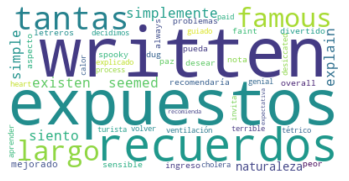

------------------------------
PUNTO 5
------------------------------
---------------Dispersion Plot---------------


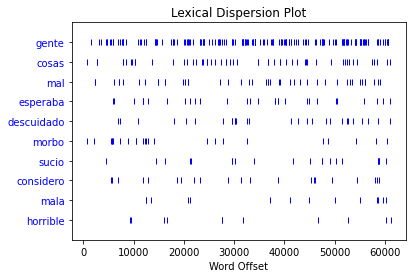

------------------------------
PUNTO 6
------------------------------
---------------Graficación libre---------------


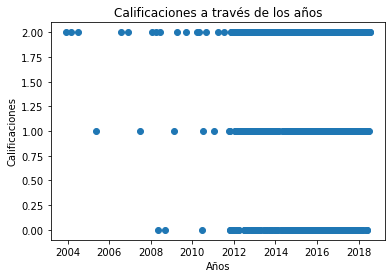

In [ ]:
tk = TweetTokenizer()
names = ["Basilica Colegiata 560", "Mercado Hidalgo 600", "Casa de Diego Rivera 698", "Universidad de Guanajuato 900", "Alhóndiga 930", "Teatro Juárez 1,010", "Jardín de la Unión 1,134", "Callejón del Beso 1,360", "Monumento Pípila 1,620", "Museo de las Momias 1,650"]

for name in names:
    print("-"*80)
    print(name.upper())
    print("-"*80)
    path = r"/content/drive/MyDrive/opiniones.xlsx"
    opiniones_data = pd.read_excel(path,sheet_name=name)
    opiniones_data["Fecha"]= pd.to_datetime(opiniones_data["Fecha"])
    opiniones_data = opiniones_data.sort_values(by="Fecha")
    opiniones, generos, nac_inter, edad, scores,longitudes,fechas = extract_columns(opiniones_data)
    opiniones_org = np.copy(opiniones)
  
    #Punto 1
    print("-"*30)
    print("PUNTO 1")
    print("-"*30)
    print("---------------Estadísticas---------------")
    opiniones = remove_stopwords(opiniones)    
    basic_statistics(opiniones, generos, nac_inter, edad, scores,longitudes,name)
    vocabulary,dict_indices,fdist,corpus_palabras = construct_vocabulary(opiniones)
    BOW = build_bow_tr(opiniones,vocabulary,dict_indices)
    #Punto 2
    print("-"*30)
    print("PUNTO 2")
    print("-"*30)
    print("---------------Word Cloud---------------")
    dict_kbest,dict_indice_invertido = get_dict_k_best(50,BOW,dict_indices,vocabulary,fdist,scores)
    makeImage(dict_kbest)
    #Punto 3
    print("-"*30)
    print("PUNTO 3")
    print("-"*30)
    print("---------------Analisis LSA---------------")
    lsa_analysis(opiniones,generos,nac_inter,edad,numero_topics=3)

    #Punto 4
    print("-"*30)
    print("PUNTO 4")
    print("-"*30)
    print("---------------Word Cloud Uni, Bi, Tri---------------")
    BOWs_and_cloud_construction(opiniones,opiniones_org,1000,scores)

    #Punto 5
    print("-"*30)
    print("PUNTO 5")
    print("-"*30)
    print("---------------Dispersion Plot---------------")
    get_dispersion_plot(BOW,scores,dict_indice_invertido,corpus_palabras)

    #Punto 6
    print("-"*30)
    print("PUNTO 6")
    print("-"*30)
    print("---------------Graficación libre---------------")
    plt.scatter(fechas, scores)
    plt.title("Calificaciones a través de los años")
    plt.ylabel("Calificaciones")
    plt.xlabel("Años")
    plt.show()
